## l2hmc

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 120
%load_ext rich
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 120 seconds


In [2]:
import matplotx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
plt.style.use('~/.config/matplotlib/stylelib/molokai.mplstyle')
plt.rcParams['figure.dpi'] = 150
sns.set_palette(['#FF5252', '#228BE6', '#40C057', '#E64980', '#14AABF', '#BE4BDB'])
#sns.set_palette(['#00CCFF', '#FF5252', '#63FF5B', '#AE81FF', '#Fd971f'])
plt.rcParams['image.cmap'] = 'viridis'

In [3]:
import os
import sys
from pathlib import Path

modulepath = Path(os.getcwd()).parent.parent.parent
if modulepath.as_posix() not in sys.path:
    sys.path.append(modulepath.as_posix())

In [4]:
extras = modulepath.joinpath('l2hmc-qcd')
if extras.as_posix() not in sys.path:
    sys.path.append(extras.as_posix())

In [5]:
import torch

import numpy as np
import tensorflow as tf

from src.l2hmc.configs import DynamicsConfig
from src.l2hmc.lattice.pytorch.lattice import Lattice as ptLattice
from src.l2hmc.lattice.tensorflow.lattice import Lattice as tfLattice

from src.l2hmc.network.pytorch.network import NetworkFactory as ptNetworkFactory
from src.l2hmc.network.tensorflow.network import NetworkFactory as tfNetworkFactory

2022-01-10 13:35:20.309700: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define configurations

Note: We use a shared set of configuration objects for both the `pytorch` and `tensorflow` implementations

In [6]:
from src.l2hmc.configs import InputSpec, NetWeights, NetworkConfig, NetWeight
from src.l2hmc.configs import NetworkConfig, InputSpec, NetWeights
from src.l2hmc.configs import LossConfig

beta = 1.
xshape = (128, 8, 8, 2)
nleapfrog = 5 
eps_init = 0.005
batch_size = xshape[0]
xdim = np.cumprod(xshape[1:])[-1]

# scaling factors multiplying the   (s , t ,  q) network functions
net_weights = NetWeights(x=NetWeight(1., 1., 1.),
                         v=NetWeight(1., 1., 1.))

net_config = NetworkConfig(units=[16, 16, 16, 16],  # sizes of hidden layers
                           dropout_prob=0.,  # dropout probability
                           activation_fn='relu',  # activation fn
                           use_batch_norm=False)  # use batch_norm

input_spec = InputSpec(xshape=xshape,
                       # note: we stack the input to the xNetwork
                       # as [cos(x), sin(x)], hence (xdim, 2) below
                       xnet={'x': (xdim, 2), 'v': (xdim,)},
                       vnet={'x': (xdim,), 'v': (xdim,)})

dynamics_config = DynamicsConfig(xdim=xdim,
                                 eps=eps_init,
                                 nleapfrog=nleapfrog,
                                 eps_fixed=False,
                                 use_ncp=True,
                                 use_split_xnets=True,
                                 use_separate_networks=True)

loss_config = LossConfig(use_mixed_loss=True,
                         plaq_weight=0.,
                         charge_weight=0.01)

## Build `tensorflow` Dynamics object

In [7]:
from src.l2hmc.lattice.tensorflow.lattice import Lattice as tfLattice
from src.l2hmc.dynamics.tensorflow.dynamics import Dynamics as tfDynamics
from src.l2hmc.network.tensorflow.network import NetworkFactory as tfNetworkFactory
from src.l2hmc.loss.tensorflow.loss import LatticeLoss as tfLatticeLoss

tf_lattice = tfLattice(xshape)
potential_fn_tf = tf_lattice.action

tf_net_factory = tfNetworkFactory(input_spec=input_spec,
                                  net_weights=net_weights,
                                  network_config=net_config)

dynamics_tf = tfDynamics(potential_fn=potential_fn_tf,
                         config=dynamics_config,
                         network_factory=tf_net_factory,
                         verbose=True)

loss_tf = tfLatticeLoss(lattice=tf_lattice, loss_config=loss_config)

## Build `pytorch` Dynamics object

In [8]:
from src.l2hmc.lattice.pytorch.lattice import Lattice as ptLattice
from src.l2hmc.dynamics.pytorch.dynamics import Dynamics as ptDynamics
from src.l2hmc.network.pytorch.network import NetworkFactory as ptNetworkFactory
from src.l2hmc.loss.pytorch.loss import LatticeLoss as ptLatticeLoss

optim = torch.optim

pt_lattice = ptLattice(xshape)
potential_fn_pt = pt_lattice.action

pt_net_factory = ptNetworkFactory(input_spec=input_spec,
                                  net_weights=net_weights,
                                  network_config=net_config)

dynamics_pt = ptDynamics(potential_fn=potential_fn_pt,
                         config=dynamics_config,
                         network_factory=pt_net_factory)


loss_pt = ptLatticeLoss(lattice=pt_lattice,
                        loss_config=loss_config)

optimizer_pt = optim.Adam(dynamics_pt.parameters())
loss_pt = ptLatticeLoss(lattice=pt_lattice, loss_config=loss_config)

## Test lattice methods

In [9]:
xinit_tf = tf.random.uniform(xshape, *(-np.pi, np.pi))
xinit_np = xinit_tf.numpy()
xinit_pt = torch.tensor(xinit_np, requires_grad=True)

wl_init_tf = tf_lattice.wilson_loops(x=xinit_tf)
wl_init_pt = pt_lattice.wilson_loops(x=xinit_pt)

dxinit = xinit_tf.numpy() - xinit_pt.detach().numpy()
dwl_init = wl_init_tf.numpy() - wl_init_pt.detach().numpy()
dwl_init.sum()
dwl_init.mean()
dxinit.sum()

0.0

0.0

0.0

# Training

## Try training `pytorch` Dynamics

In [10]:
import time
from rich import print
from torch import optim
from src.l2hmc.trainers.pytorch.trainer import train_step as train_step_pt
from src.l2hmc.dynamics.pytorch.dynamics import random_angle
from rich.console import Console

dynamics_pt.train()
optimizer_pt = optim.Adam(dynamics_pt.parameters())
xpt = random_angle(xinit_pt.shape)
xpt = xpt.reshape(xpt.shape[0], -1)

console = Console(color_system='truecolor', log_path=False)

def dict_summary(d):
    strs = []
    for key, val in d.items():
        if isinstance(val, dict):
            strs.append(f'{key}={dict_summary(val)}')
        else:
            try:
                strs.append(f'{key}={np.mean(val):.3g}')
            except:
                strs.append(f'{key}={val.mean():.3g}')
            
    return strs

Dynamics(
  (networks): ModuleDict(
    (xnet): ModuleDict(
      (0): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
      )
      (1): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
      )
      (2): ModuleDict(
        (first): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Linear(in_features=16, out_features=128, bias=True)
        )
        (second): Network(
          (x_layer): Linear(in_features=256, out_features=16, bias=True)
          (v_layer): Linear(in_features=128, out_features=16, bias=True)
          (hidden_layers): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
          )
          (scale): Linear(in_features=16, out_features=128, bias=True)
          (transl): Linear(in_features=16, out_features=128, bias=True)
          (transf): Li

/Users/saforem2/projects/l2hmc-qcd/src/l2hmc/dynamics/pytorch/dynamics.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((a - b) * torch.rand(shape) + b).requires_grad_(requires_grad)


In [11]:
history_pt = {}
era_metrics_pt = {}
accs_pt = {}
losses_pt = {}

nera = 10
nepoch = 50
print(
    f'''Training for:
      - nera: {nera}
      - nepoch: {nepoch}
    at beta: {beta}
    with input_shape: {xpt.shape}
    '''
)
for era in range(nera):
    losses_pt[str(era)] = []
    accs_pt[str(era)] = []
    era_metrics_pt[str(era)] = {}
    estart = time.time()
    for epoch in range(nepoch):
        xpt, metrics_pt = train_step_pt((xpt, beta),
                                        dynamics=dynamics_pt,
                                        optimizer=optimizer_pt,
                                        loss_fn=loss_pt)
        losses_pt[str(era)].append(metrics_pt['loss'])
        accs_pt[str(era)].append(metrics_pt['acc'].detach().numpy())
        
        mstr = [f'epoch={epoch}',
                f'dt={metrics_pt["dt"]:.3g}',
                f'loss={metrics_pt["loss"]:.3g}',
                f'acc={metrics_pt["acc"].mean():.3g}']
        if epoch % 10 == 0:
            console.log(', '.join(mstr))
        for key, val in metrics_pt.items():
            try:
                history_pt[key].append(val)
            except KeyError:
                history_pt[key] = [val]
    
    avg_loss = np.mean(losses_pt[str(era)])
    avg_acc = np.mean(accs_pt[str(era)])
    
    era_metrics_pt[str(era)]['acc'] = avg_acc
    era_metrics_pt[str(era)]['loss'] = avg_loss
    
    console.rule()
    console.log(f'Completed era: {era} in: {time.time() - estart:.4g}s')
    console.log('metrics: ' + ', '.join([f'era: {era}',
                                         f'avg_loss: {avg_loss:.4g}',
                                         f'avg_acc: {avg_acc:.4g}']))
    console.rule()

Training for:
      - nera: 10
      - nepoch: 50
    at beta: 1.0
    with input_shape: torch.Size([128, 128])

[13:35:50] epoch=0, dt=0.487, loss=21.2, acc=0.984

[13:35:54] epoch=10, dt=0.352, loss=8.36, acc=0.973

[13:35:58] epoch=20, dt=0.347, loss=2.77, acc=0.964

[13:36:02] epoch=30, dt=0.353, loss=0.104, acc=0.951

[13:36:05] epoch=40, dt=0.371, loss=0.834, acc=0.944

─────────────────────────────────────────────────────────────────────────────────────────────

[13:36:09] Completed era: 0 in: 18.85s

           metrics: era: 0, avg_loss: 4.068, avg_acc: 0.9596

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.358, loss=-5.32, acc=0.923

[13:36:13] epoch=10, dt=0.329, loss=-6.21, acc=0.905

[13:36:16] epoch=20, dt=0.41, loss=-7.16, acc=0.881

[13:36:19] epoch=30, dt=0.329, loss=-11.5, acc=0.914

[13:36:23] epoch=40, dt=0.335, loss=-13.1, acc=0.931

─────────────────────────────────────────────────────────────────────────────────────────────

[13:36:26] Completed era: 1 in: 17.26s

           metrics: era: 1, avg_loss: -8.2, avg_acc: 0.9079

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.335, loss=-10.4, acc=0.873

[13:36:30] epoch=10, dt=0.325, loss=-17.4, acc=0.877

[13:36:33] epoch=20, dt=0.34, loss=-18.5, acc=0.887

[13:36:37] epoch=30, dt=0.367, loss=-30.2, acc=0.887

[13:36:40] epoch=40, dt=0.344, loss=-28, acc=0.855

─────────────────────────────────────────────────────────────────────────────────────────────

[13:36:43] Completed era: 2 in: 17.15s

           metrics: era: 2, avg_loss: -21.77, avg_acc: 0.8749

─────────────────────────────────────────────────────────────────────────────────────────────

[13:36:44] epoch=0, dt=0.448, loss=-38, acc=0.859

[13:36:47] epoch=10, dt=0.347, loss=-37.3, acc=0.834

[13:36:50] epoch=20, dt=0.318, loss=-42.6, acc=0.828

[13:36:54] epoch=30, dt=0.357, loss=-33.2, acc=0.842

[13:36:58] epoch=40, dt=0.476, loss=-46.9, acc=0.814

─────────────────────────────────────────────────────────────────────────────────────────────

[13:37:02] Completed era: 3 in: 19.23s

           metrics: era: 3, avg_loss: -38.95, avg_acc: 0.8351

─────────────────────────────────────────────────────────────────────────────────────────────

[13:37:03] epoch=0, dt=0.644, loss=-54.3, acc=0.816

[13:37:09] epoch=10, dt=0.845, loss=-38.7, acc=0.827

[13:37:14] epoch=20, dt=0.362, loss=-54.6, acc=0.786

[13:37:18] epoch=30, dt=0.448, loss=-54.7, acc=0.856

[13:37:23] epoch=40, dt=0.536, loss=-66.5, acc=0.876

─────────────────────────────────────────────────────────────────────────────────────────────

[13:37:29] Completed era: 4 in: 26.8s

           metrics: era: 4, avg_loss: -55.42, avg_acc: 0.8217

─────────────────────────────────────────────────────────────────────────────────────────────

[13:37:30] epoch=0, dt=0.575, loss=-74.6, acc=0.82

[13:37:37] epoch=10, dt=0.835, loss=-51.2, acc=0.791

[13:37:44] epoch=20, dt=0.721, loss=-72.5, acc=0.796

[13:37:50] epoch=30, dt=0.526, loss=-77.7, acc=0.832

[13:37:55] epoch=40, dt=0.489, loss=-73.5, acc=0.825

─────────────────────────────────────────────────────────────────────────────────────────────

[13:38:00] Completed era: 5 in: 30.83s

           metrics: era: 5, avg_loss: -66.91, avg_acc: 0.8165

─────────────────────────────────────────────────────────────────────────────────────────────

[13:38:01] epoch=0, dt=0.538, loss=-53.5, acc=0.788

[13:38:06] epoch=10, dt=0.473, loss=-72.3, acc=0.789

[13:38:12] epoch=20, dt=0.49, loss=-89.1, acc=0.793

[13:38:17] epoch=30, dt=0.735, loss=-80.5, acc=0.811

[13:38:23] epoch=40, dt=0.494, loss=-83.2, acc=0.798

─────────────────────────────────────────────────────────────────────────────────────────────

[13:38:27] Completed era: 6 in: 27.09s

           metrics: era: 6, avg_loss: -72.82, avg_acc: 0.7994

─────────────────────────────────────────────────────────────────────────────────────────────

[13:38:28] epoch=0, dt=0.506, loss=-68, acc=0.786

[13:38:32] epoch=10, dt=0.461, loss=-90.3, acc=0.801

[13:38:37] epoch=20, dt=0.478, loss=-76.2, acc=0.803

[13:38:42] epoch=30, dt=0.44, loss=-108, acc=0.807

[13:38:47] epoch=40, dt=0.562, loss=-92.2, acc=0.827

─────────────────────────────────────────────────────────────────────────────────────────────

[13:38:51] Completed era: 7 in: 23.57s

           metrics: era: 7, avg_loss: -79.9, avg_acc: 0.8076

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.405, loss=-102, acc=0.823

[13:38:55] epoch=10, dt=0.393, loss=-61.1, acc=0.746

[13:38:59] epoch=20, dt=0.399, loss=-74.3, acc=0.753

[13:39:03] epoch=30, dt=0.352, loss=-89.4, acc=0.773

[13:39:07] epoch=40, dt=0.348, loss=-87.3, acc=0.722

─────────────────────────────────────────────────────────────────────────────────────────────

[13:39:10] Completed era: 8 in: 19.24s

           metrics: era: 8, avg_loss: -84.78, avg_acc: 0.7966

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.372, loss=-84.7, acc=0.797

[13:39:14] epoch=10, dt=0.322, loss=-76, acc=0.782

[13:39:17] epoch=20, dt=0.323, loss=-80.6, acc=0.813

[13:39:21] epoch=30, dt=0.327, loss=-102, acc=0.777

[13:39:24] epoch=40, dt=0.329, loss=-92, acc=0.817

─────────────────────────────────────────────────────────────────────────────────────────────

[13:39:27] Completed era: 9 in: 16.5s

           metrics: era: 9, avg_loss: -89.68, avg_acc: 0.81

─────────────────────────────────────────────────────────────────────────────────────────────

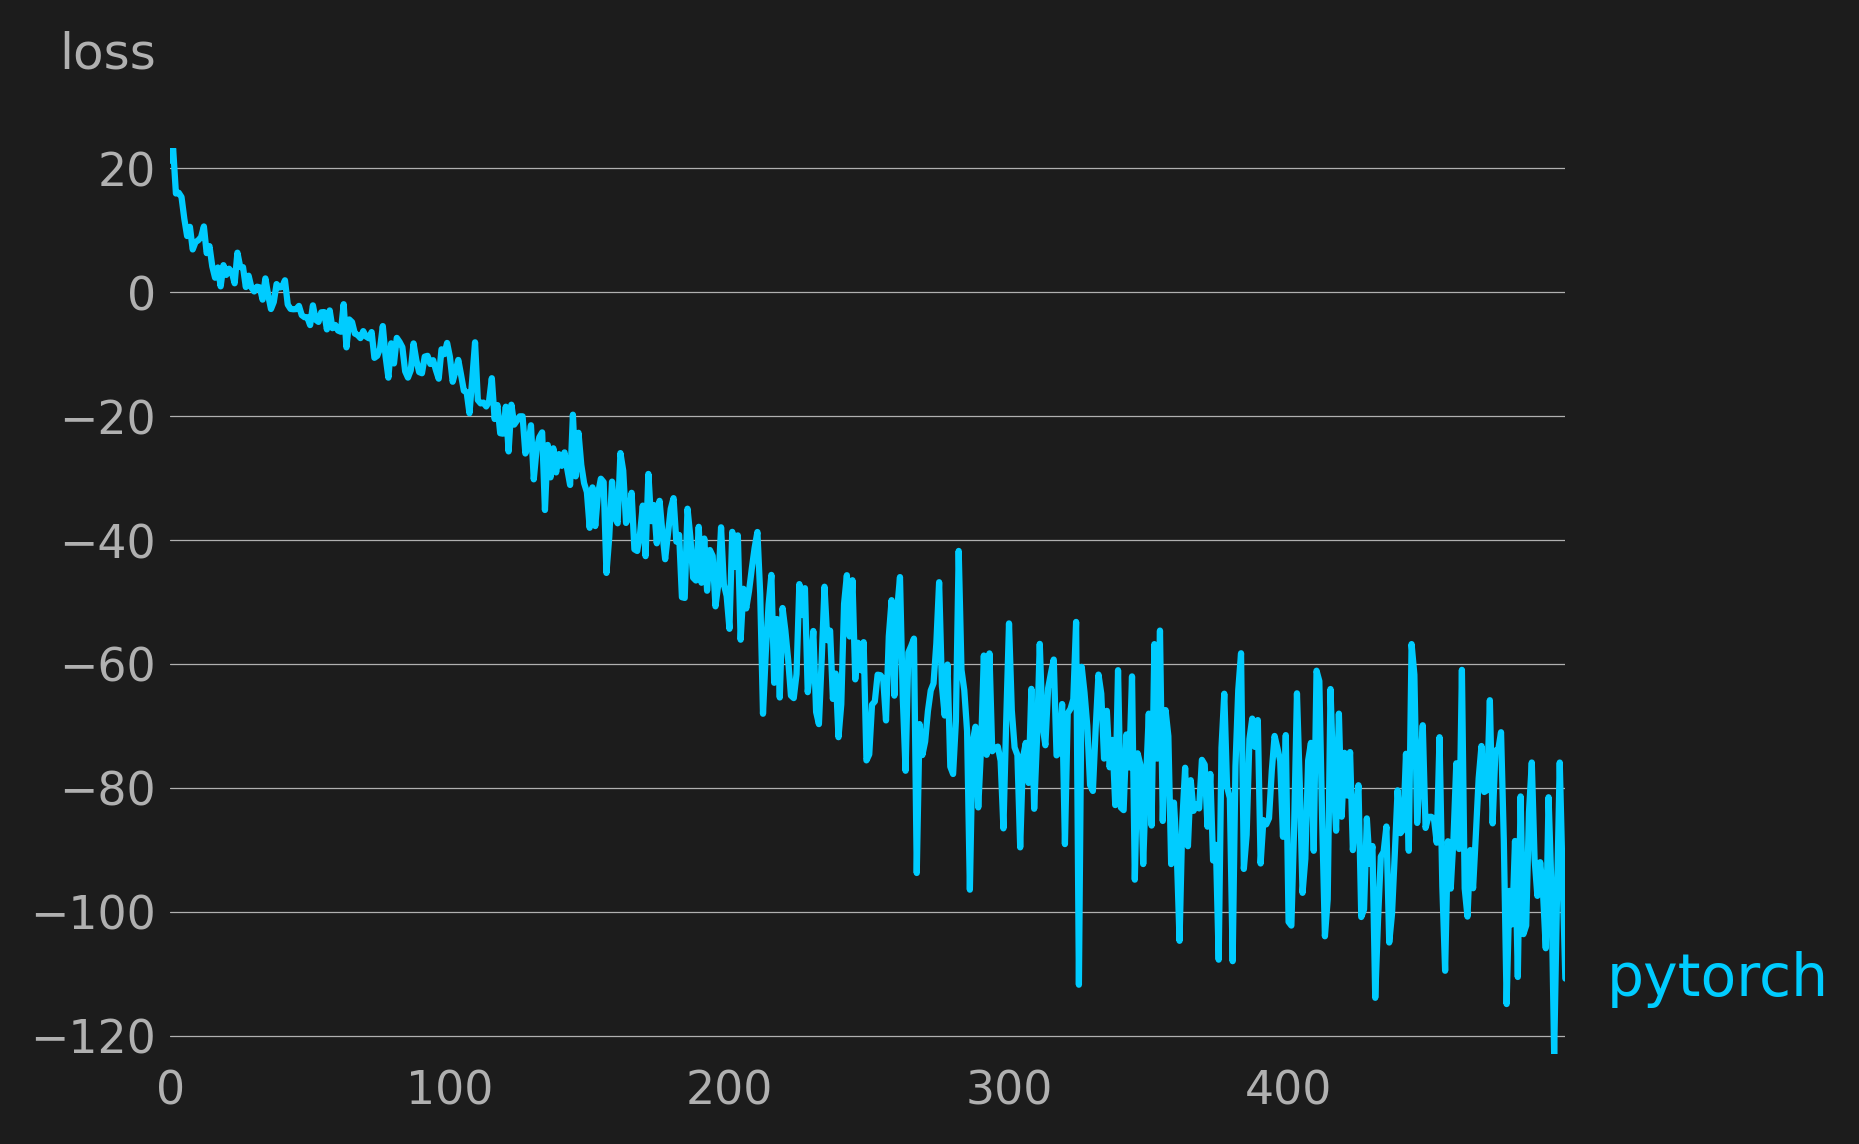

In [13]:
%matplotlib inline
import matplotx
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
plt.style.use('~/.config/matplotlib/stylelib/molokai.mplstyle')
plt.rcParams['figure.dpi'] = 150
sns.set_palette(['#00CCFF', '#FF5252', '#63FF5B', '#AE81FF', '#Fd971f'])
plt.rcParams['image.cmap'] = 'viridis'

losses_arr = np.stack(list(losses_pt.values())).flatten()

with plt.style.context(matplotx.styles.dufte):
    fig, ax  = plt.subplots()
    _ = ax.plot(np.arange(len(losses_arr)), losses_arr, label='pytorch');
    matplotx.ylabel_top("loss")  # move ylabel to the top, rotate
    matplotx.line_labels()  # line labels to the right

## `tensorflow`:

In [14]:
import time
from src.l2hmc.configs import LossConfig
from src.l2hmc.loss.tensorflow.loss import LatticeLoss as tfLatticeLoss
from src.l2hmc.trainers.tensorflow.trainer import train_step as train_step_tf
from src.l2hmc.trainers.tensorflow.trainer import train_step as train_step_tf

from src.l2hmc.trainers.tensorflow.trainer import train_step as train_step_tf

optimizer_tf = tf.keras.optimizers.Adam()

dynamics_tf.compile(optimizer=optimizer_tf, loss=loss_tf)
train_step_tf_ = tf.function(train_step_tf)

In [15]:
history_tf = {}
era_metrics_tf = {}
accs_tf = {}
losses_tf = {}

console.log(f'''
Training for:
  - nera: {nera}
  - nepoch: {nepoch}
at 
  - beta: {beta}
with
  - input_shape: {dynamics_tf.xshape}
''')

xtf = tf.random.uniform(dynamics_tf.xshape, *(-np.pi, np.pi))
xtf = tf.reshape(xtf, (xtf.shape[0], -1))
for era in range(nera):
    losses_tf[str(era)] = []
    accs_tf[str(era)] = []
    era_metrics_tf[str(era)] = {}
    estart = time.time()
    for epoch in range(nepoch):
        tstart = time.time()
        xtf, metrics_tf = train_step_tf_((xtf, tf.constant(beta)),
                                         dynamics=dynamics_tf,
                                         optimizer=optimizer_tf,
                                         loss_fn=loss_tf)
        metrics_tf['dt'] = time.time() - tstart
        losses_tf[str(era)].append(metrics_tf['loss'])
        accs_tf[str(era)].append(metrics_tf['acc'].numpy())
        
        mstr = [f'epoch={epoch}',
                f'dt={metrics_tf["dt"]:.3g}',
                f'loss={metrics_tf["loss"]:.3g}',
                f'acc={tf.reduce_mean(metrics_tf["acc"]):.3g}']
        if epoch % 10 == 0:
            console.log(', '.join(mstr))
        for key, val in metrics_tf.items():
            try:
                history_tf[key].append(val)
            except KeyError:
                history_tf[key] = [val]
    
    avg_loss = np.mean(losses_tf[str(era)])
    avg_acc = np.mean(accs_tf[str(era)])
    
    era_metrics_tf[str(era)]['acc'] = avg_acc
    era_metrics_tf[str(era)]['loss'] = avg_loss
    
    console.rule()
    console.log(f'Completed era: {era} in: {time.time() - estart:.4g}s')
    console.log('metrics: ' + ', '.join([f'era: {era}',
                                         f'avg_loss: {avg_loss:.4g}',
                                         f'avg_acc: {avg_acc:.4g}']))
    console.rule()

[13:41:16]                                                                                   
           Training for:                                                                     
             - nera: 10                                                                      
             - nepoch: 50                                                                    
           at                                                                                
             - beta: 1.0                                                                     
           with                                                                              
             - input_shape: (128, 8, 8, 2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-01-10 13:41:38.840721: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[13:41:45] epoch=0, dt=29, loss=23.9, acc=0.969

[13:41:46] epoch=10, dt=0.0577, loss=11, acc=0.908

           epoch=20, dt=0.0538, loss=6.16, acc=0.893

[13:41:47] epoch=30, dt=0.0557, loss=1.99, acc=0.872

           epoch=40, dt=0.0543, loss=-0.318, acc=0.825

─────────────────────────────────────────────────────────────────────────────────────────────

[13:41:48] Completed era: 0 in: 31.79s

           metrics: era: 0, avg_loss: 4.854, avg_acc: 0.8806

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.0845, loss=-0.128, acc=0.817

[13:41:49] epoch=10, dt=0.0717, loss=-2.38, acc=0.755

           epoch=20, dt=0.0663, loss=-6.58, acc=0.753

[13:41:50] epoch=30, dt=0.0565, loss=-7.77, acc=0.782

[13:41:51] epoch=40, dt=0.0635, loss=-7.66, acc=0.789

─────────────────────────────────────────────────────────────────────────────────────────────

           Completed era: 1 in: 3.267s

           metrics: era: 1, avg_loss: -4.324, avg_acc: 0.7794

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.0614, loss=-7.38, acc=0.781

[13:41:52] epoch=10, dt=0.0583, loss=-9.32, acc=0.778

[13:41:53] epoch=20, dt=0.0604, loss=-14, acc=0.813

           epoch=30, dt=0.0714, loss=-14.1, acc=0.777

[13:41:54] epoch=40, dt=0.0582, loss=-16.8, acc=0.803

─────────────────────────────────────────────────────────────────────────────────────────────

           Completed era: 2 in: 3.164s

           metrics: era: 2, avg_loss: -14.89, avg_acc: 0.7928

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.0704, loss=-22.8, acc=0.794

[13:41:55] epoch=10, dt=0.0661, loss=-18.9, acc=0.783

[13:41:56] epoch=20, dt=0.0744, loss=-28.8, acc=0.849

[13:41:57] epoch=30, dt=0.0742, loss=-29.7, acc=0.852

           epoch=40, dt=0.081, loss=-36.1, acc=0.876

─────────────────────────────────────────────────────────────────────────────────────────────

[13:41:58] Completed era: 3 in: 3.516s

           metrics: era: 3, avg_loss: -28.11, avg_acc: 0.8149

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.0762, loss=-45.8, acc=0.851

[13:41:59] epoch=10, dt=0.0757, loss=-42.1, acc=0.852

           epoch=20, dt=0.067, loss=-42.1, acc=0.833

[13:42:00] epoch=30, dt=0.0651, loss=-51.4, acc=0.832

[13:42:01] epoch=40, dt=0.0954, loss=-54.1, acc=0.835

─────────────────────────────────────────────────────────────────────────────────────────────

[13:42:02] Completed era: 4 in: 3.756s

           metrics: era: 4, avg_loss: -43.23, avg_acc: 0.846

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.0748, loss=-44.8, acc=0.862

[13:42:03] epoch=10, dt=0.0789, loss=-46.1, acc=0.831

           epoch=20, dt=0.0731, loss=-60.8, acc=0.843

[13:42:04] epoch=30, dt=0.103, loss=-54.1, acc=0.878

[13:42:05] epoch=40, dt=0.133, loss=-69.4, acc=0.872

─────────────────────────────────────────────────────────────────────────────────────────────

[13:42:06] Completed era: 5 in: 4.398s

           metrics: era: 5, avg_loss: -56.84, avg_acc: 0.8567

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.0966, loss=-56.3, acc=0.864

[13:42:07] epoch=10, dt=0.0867, loss=-54.4, acc=0.839

[13:42:08] epoch=20, dt=0.0817, loss=-65.8, acc=0.84

[13:42:09] epoch=30, dt=0.0907, loss=-63.1, acc=0.861

[13:42:10] epoch=40, dt=0.102, loss=-60.6, acc=0.848

─────────────────────────────────────────────────────────────────────────────────────────────

[13:42:11] Completed era: 6 in: 4.612s

           metrics: era: 6, avg_loss: -64.71, avg_acc: 0.8625

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.0804, loss=-67.4, acc=0.865

[13:42:12] epoch=10, dt=0.0896, loss=-59.8, acc=0.884

[13:42:13] epoch=20, dt=0.0896, loss=-64.3, acc=0.854

[13:42:14] epoch=30, dt=0.112, loss=-71.6, acc=0.875

[13:42:15] epoch=40, dt=0.11, loss=-87.1, acc=0.871

─────────────────────────────────────────────────────────────────────────────────────────────

[13:42:16] Completed era: 7 in: 4.958s

           metrics: era: 7, avg_loss: -74.16, avg_acc: 0.8793

─────────────────────────────────────────────────────────────────────────────────────────────

           epoch=0, dt=0.11, loss=-86.7, acc=0.889

[13:42:17] epoch=10, dt=0.108, loss=-86, acc=0.883

[13:42:18] epoch=20, dt=0.0946, loss=-91.7, acc=0.888

[13:42:19] epoch=30, dt=0.113, loss=-79.9, acc=0.912

[13:42:20] epoch=40, dt=0.115, loss=-79, acc=0.88

─────────────────────────────────────────────────────────────────────────────────────────────

[13:42:21] Completed era: 8 in: 5.66s

           metrics: era: 8, avg_loss: -84.35, avg_acc: 0.8912

─────────────────────────────────────────────────────────────────────────────────────────────

[13:42:22] epoch=0, dt=0.115, loss=-111, acc=0.891

[13:42:23] epoch=10, dt=0.102, loss=-93.5, acc=0.894

[13:42:24] epoch=20, dt=0.113, loss=-84.7, acc=0.924

[13:42:25] epoch=30, dt=0.114, loss=-96.3, acc=0.909

[13:42:26] epoch=40, dt=0.0846, loss=-107, acc=0.909

─────────────────────────────────────────────────────────────────────────────────────────────

[13:42:27] Completed era: 9 in: 5.471s

           metrics: era: 9, avg_loss: -95.83, avg_acc: 0.8987

─────────────────────────────────────────────────────────────────────────────────────────────

# Compare loss during training for `pytorch` and `tensorflow` implementations

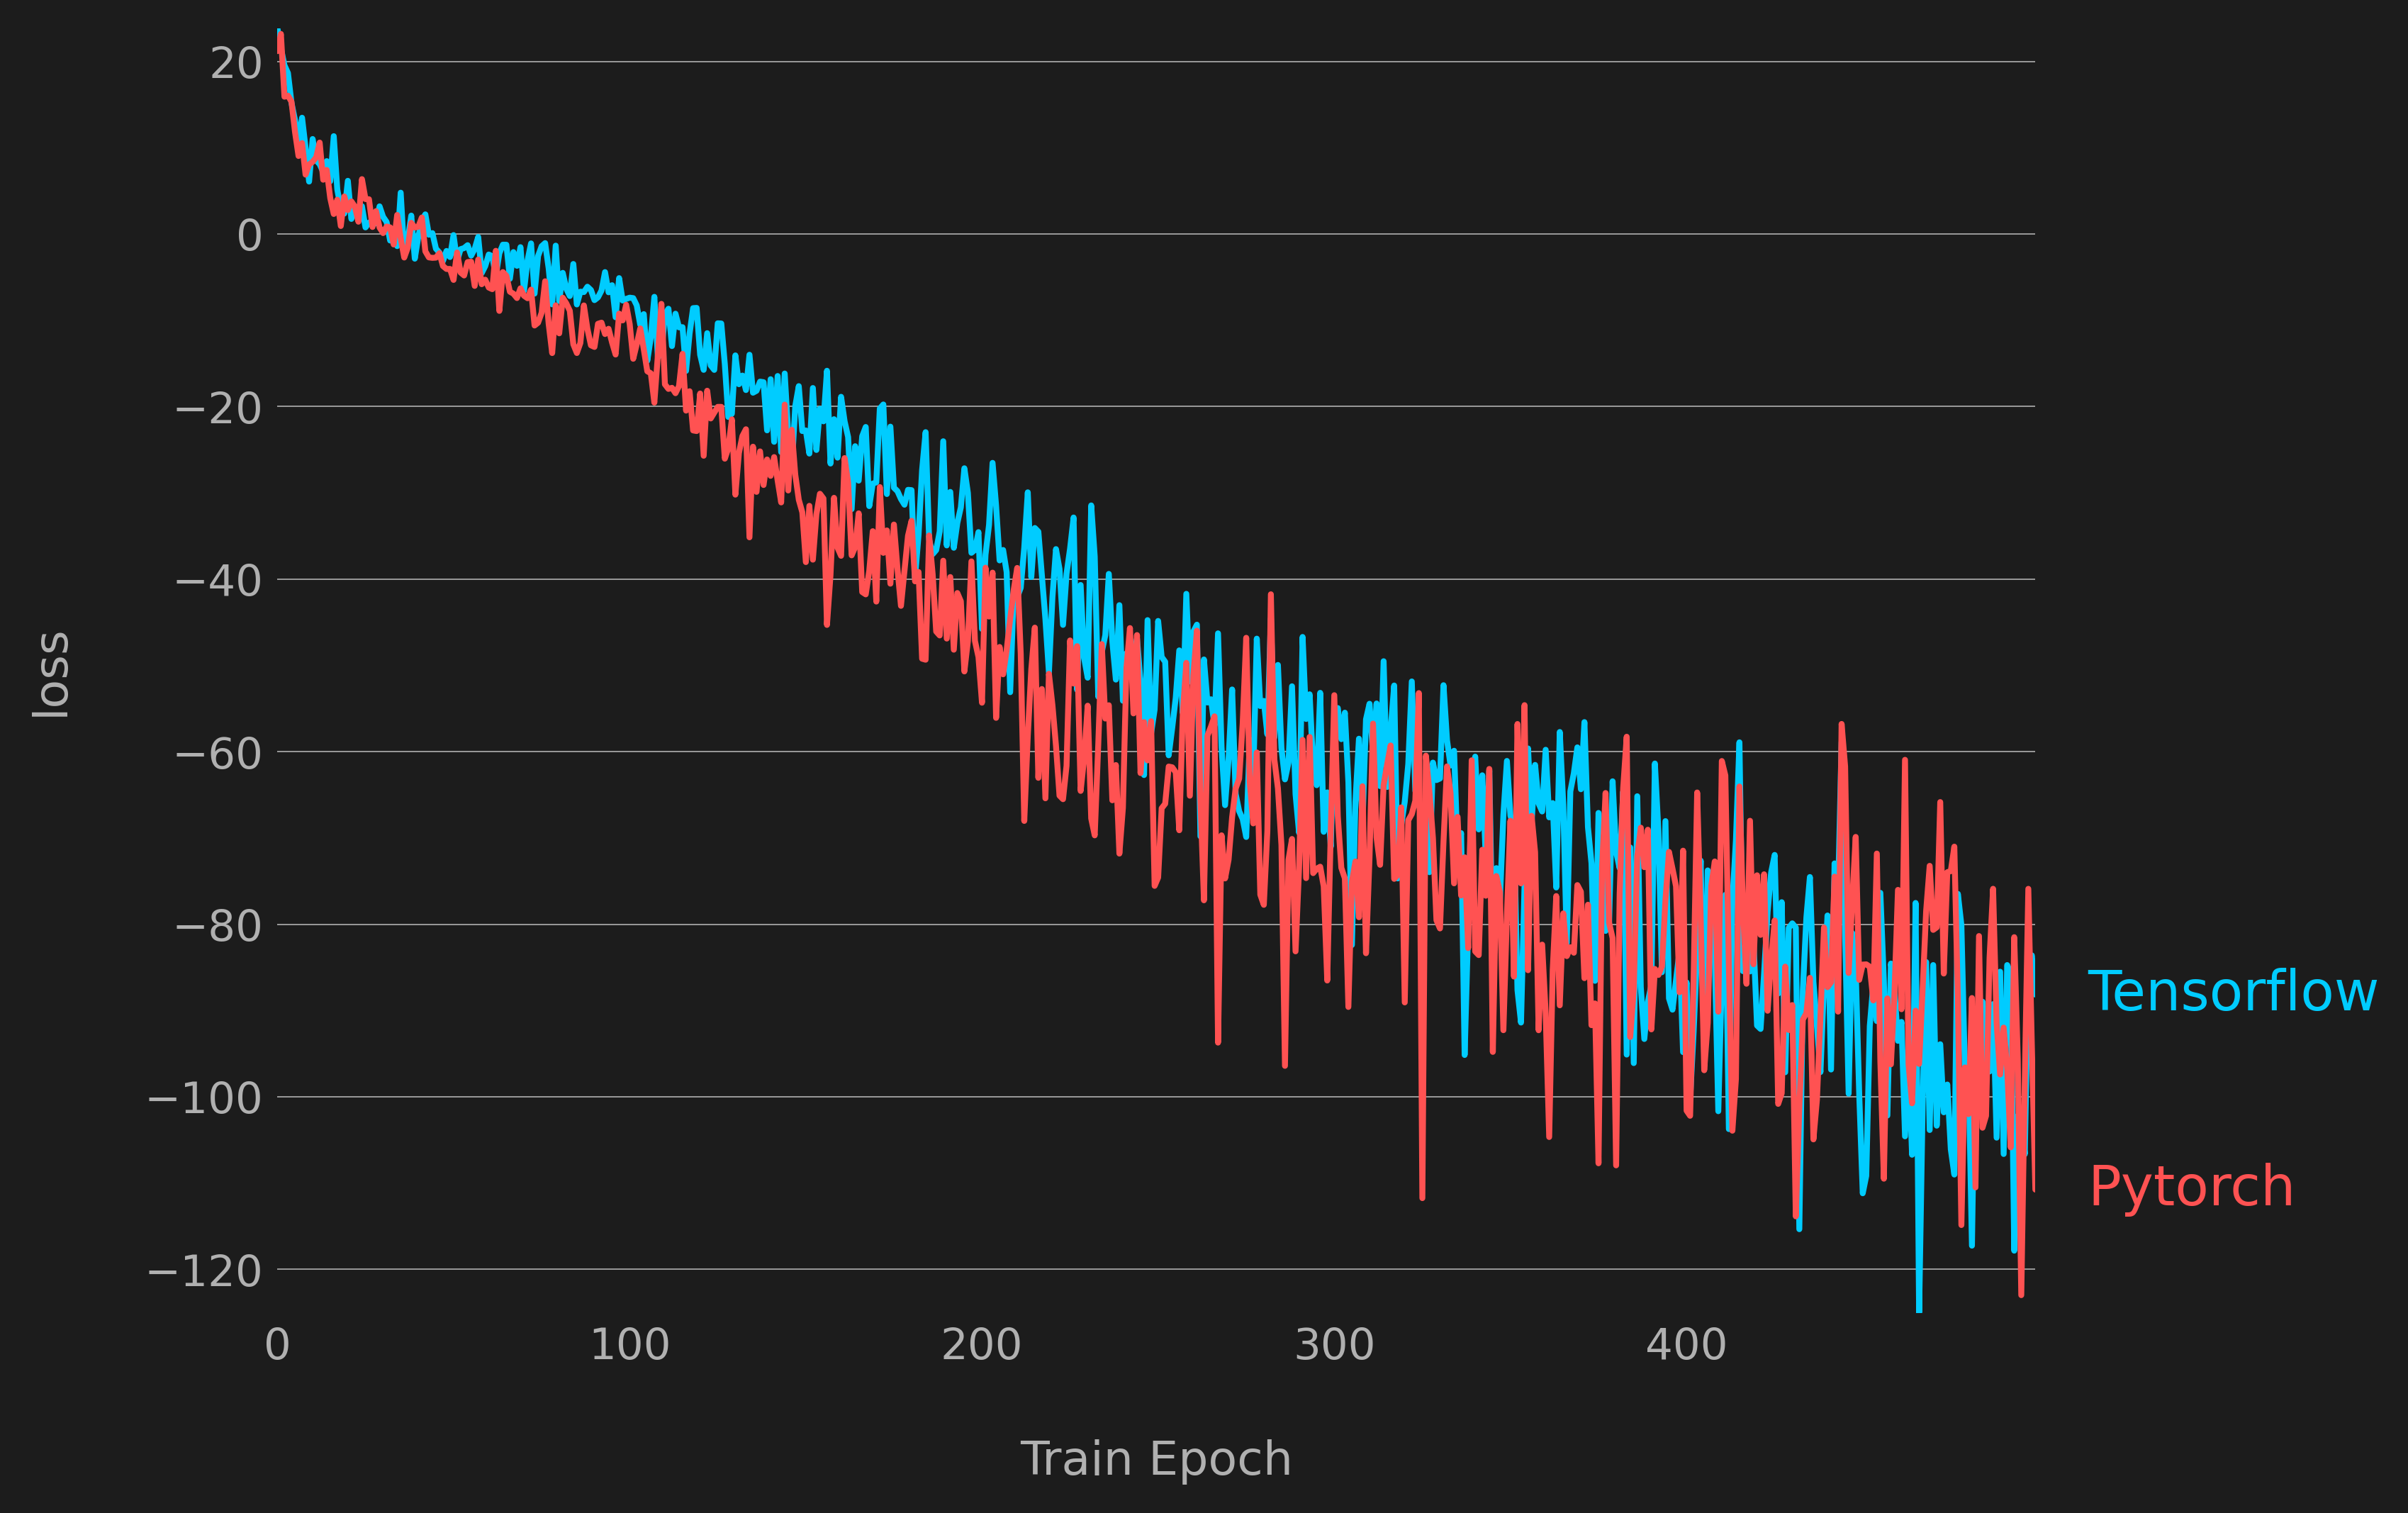

In [16]:
import matplotx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
plt.style.use('~/.config/matplotlib/stylelib/molokai.mplstyle')
plt.rcParams['figure.dpi'] = 200
sns.set_palette(['#00CCFF', '#FF5252', '#63FF5B', '#AE81FF', '#Fd971f'])
plt.rcParams['image.cmap'] = 'viridis'

losses_arr_tf = np.stack(list(losses_tf.values())).flatten()

with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(figsize=(8, 6))
    _ = ax.plot(np.arange(len(losses_arr_tf)), losses_arr_tf, label='Tensorflow');
    _ = ax.plot(np.arange(len(losses_arr)), losses_arr, label='Pytorch');
    _ = ax.set_xlabel(r'Train Epoch')
    _ = ax.set_ylabel('loss')
    matplotx.line_labels()  # line labels to the right

In [17]:
def stack_history(history):
    history_ = {}
    for key, val in history.items():
        if not isinstance(val[0], (tf.Tensor, torch.Tensor, np.ndarray, float)):
            print(f'Skipping key: {key}, val.dtype: {type(val)}')
            continue
        elif isinstance(val[0], tf.Tensor):
            history_[key] = tf.stack(val).numpy()
        elif isinstance(val[0], torch.Tensor):
            history_[key] = torch.stack(val).detach().numpy()
        elif isinstance(val[0], (float, np.ndarray)):
            history_[key] = np.stack(val)
            
    return history_

In [18]:
history_tf_ = stack_history(history_tf)
history_pt_ = stack_history(history_pt)

Skipping key: forward, val.dtype: <class 'list'>

Skipping key: backward, val.dtype: <class 'list'>

Skipping key: forward, val.dtype: <class 'list'>

Skipping key: backward, val.dtype: <class 'list'>

In [19]:
history_tf_.keys()
history_pt_.keys()

dict_keys(['acc', 'acc_mask', 'logdet', 'dt', 'loss'])

dict_keys(['acc', 'acc_mask', 'logdet', 'dt', 'loss'])

In [20]:
from typing import Optional
#sns.set_palette(['#228BE6', '#FF5252', '#40C057', '#E64980', '#14AABF', '#BE4BDB'])
plt.rcParams['figure.dpi'] = 175

FIGSIZE = (7, 3)
def plot_both(
        ytf: np.ndarray,
        ypt: np.ndarray,
        figsize: Optional[tuple[int]] = FIGSIZE,
        xlabel: Optional[str] = None,
        ylabel: Optional[str] = None,
) -> tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=figsize)
    _ = ax.plot(np.arange(ytf.shape[0]), ytf, label='Tensorflow');
    _ = ax.plot(np.arange(ypt.shape[0]), ypt, label='Pytorch');
    
    if xlabel is not None:
        _ = ax.set_xlabel(xlabel)
    if ylabel is not None:
        _ = ax.set_ylabel(ylabel)
    
    _ = ax.grid(True, color='#252525');
    matplotx.line_labels(ax=ax)
    return fig, ax

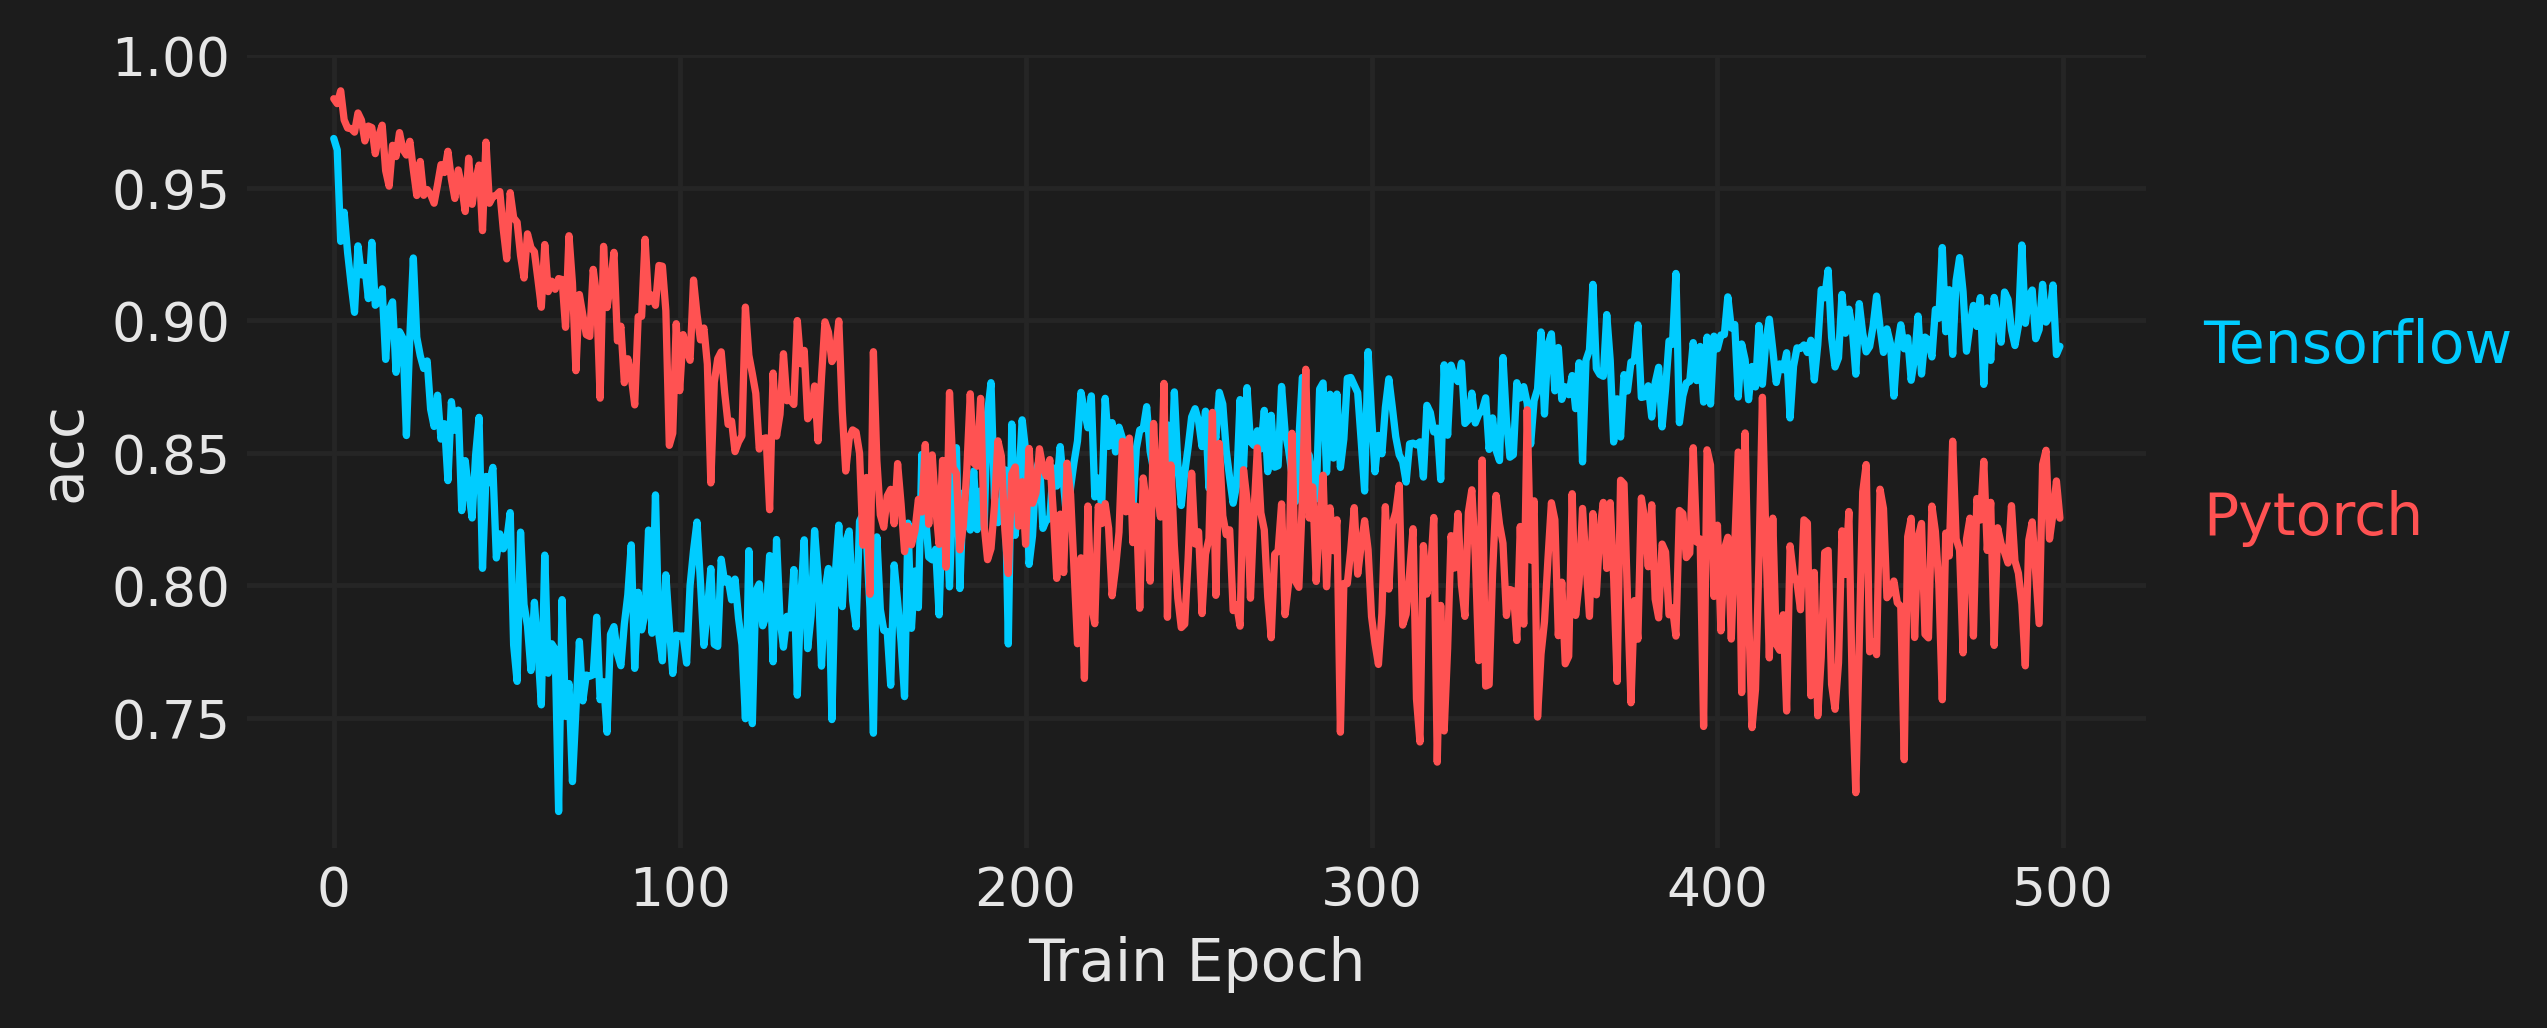

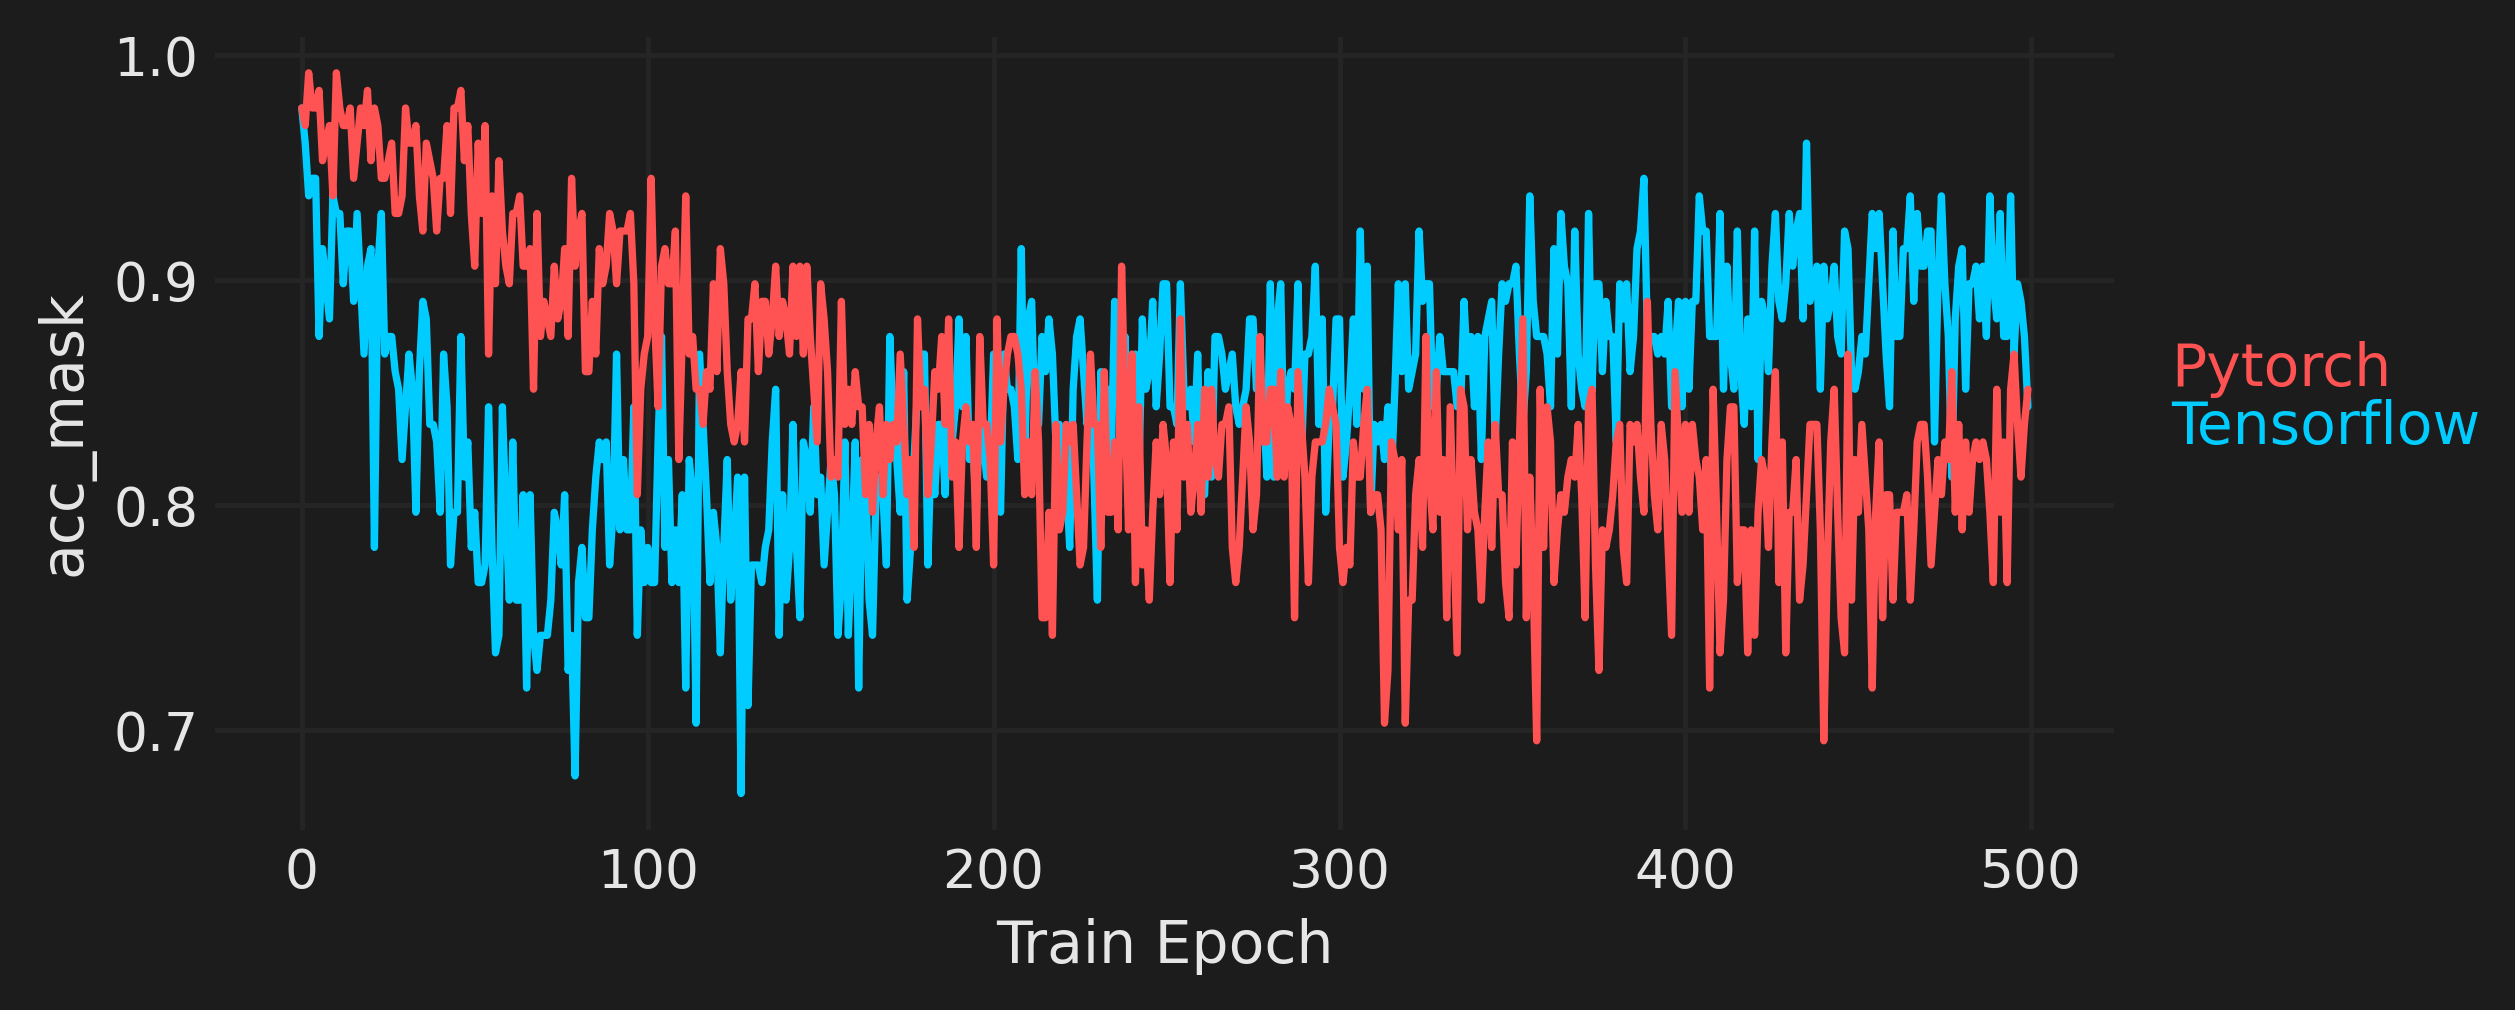

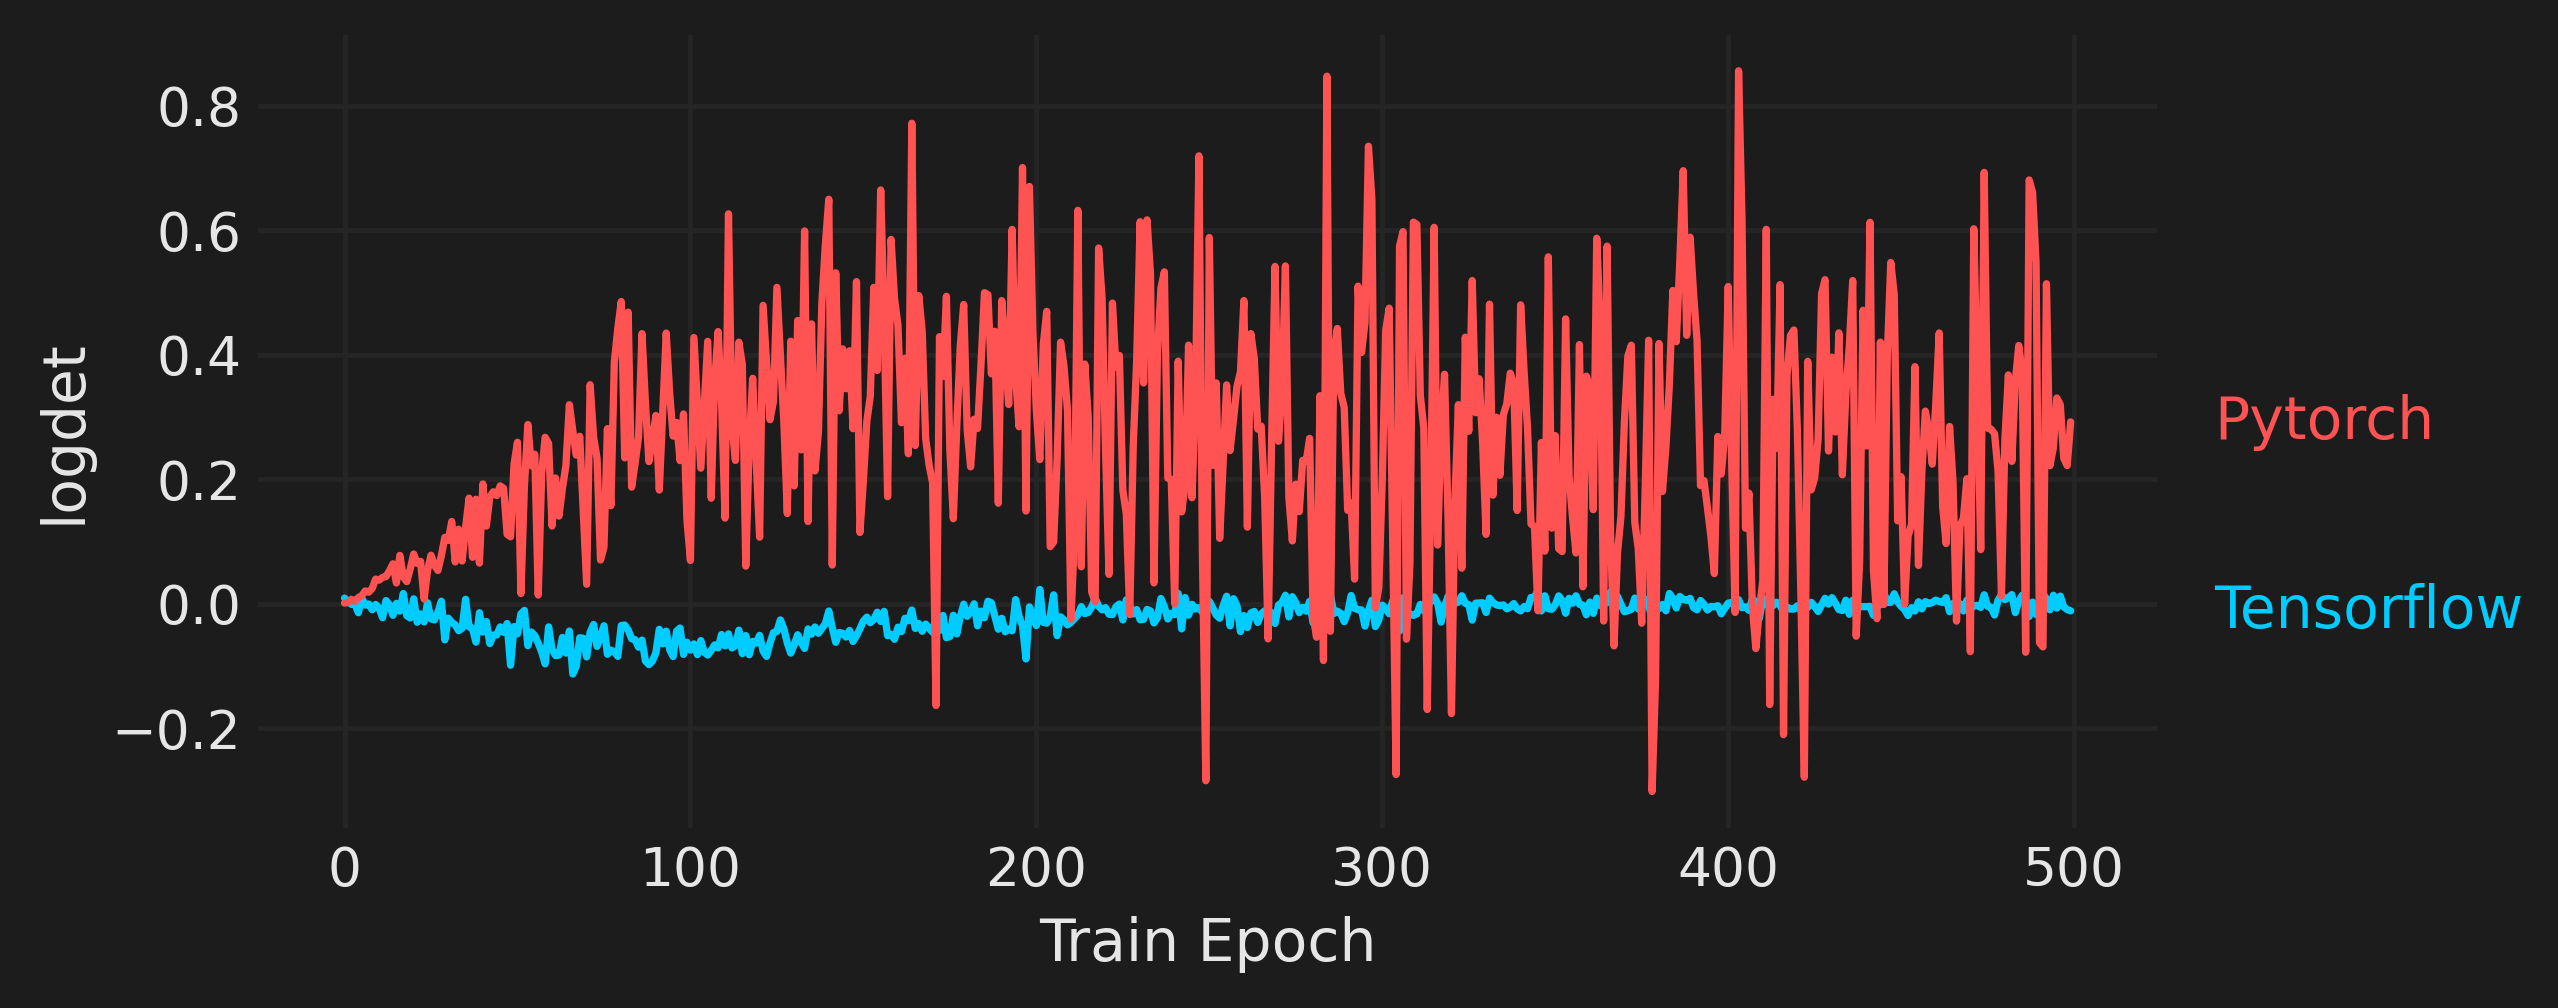

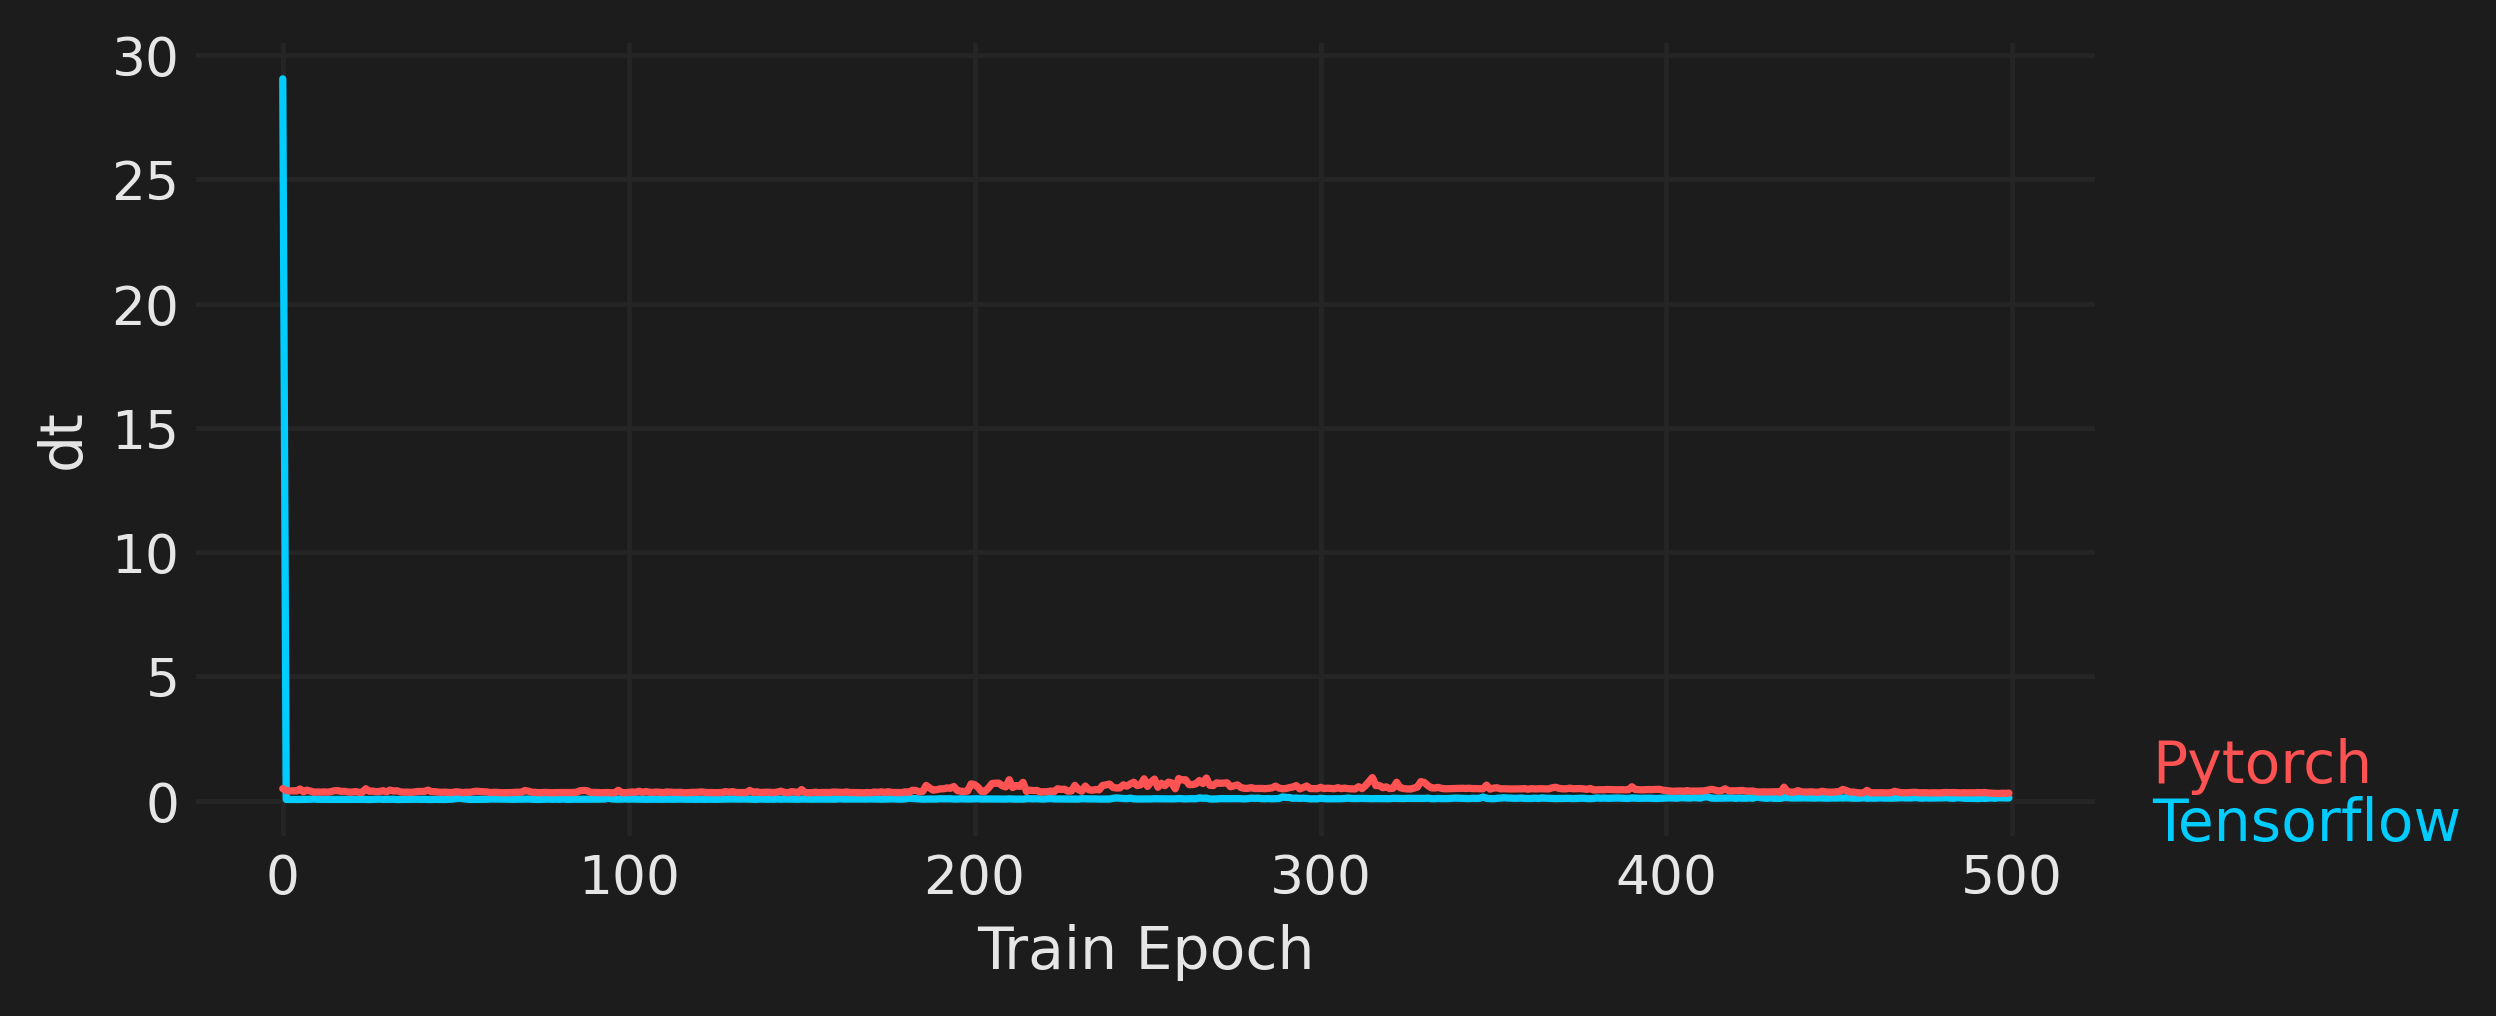

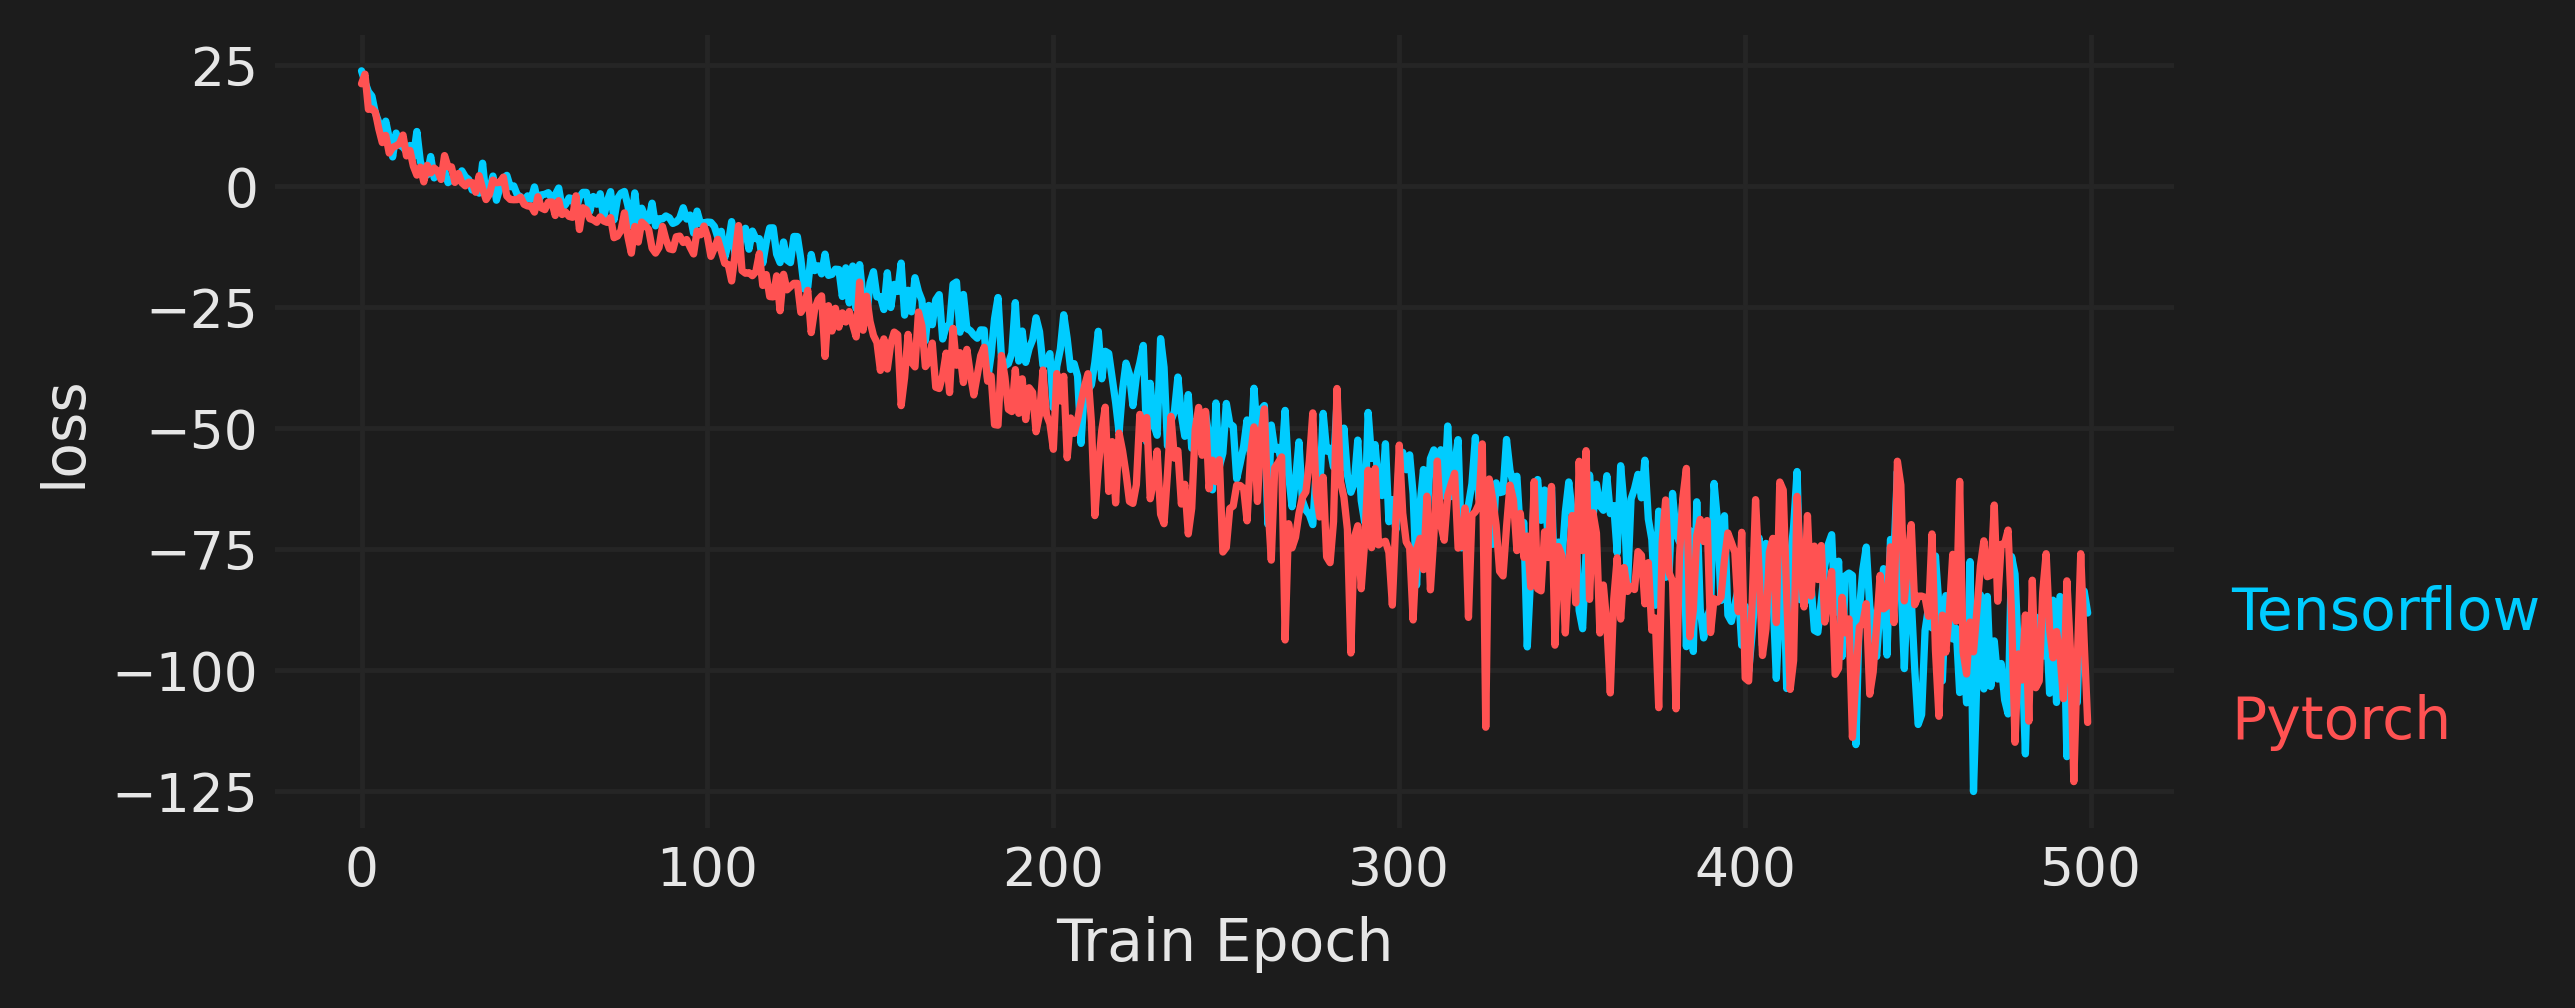

In [21]:
for key in history_tf_.keys():
    ytf = history_tf_[key]
    ypt = history_pt_[key]
    if len(ytf.shape) == 2:
        ytf = ytf.mean(1)
        ypt = ypt.mean(1)
        
    fig, ax = plot_both(ytf=ytf, ypt=ypt, figsize=(7, 3), xlabel='Train Epoch', ylabel=key)

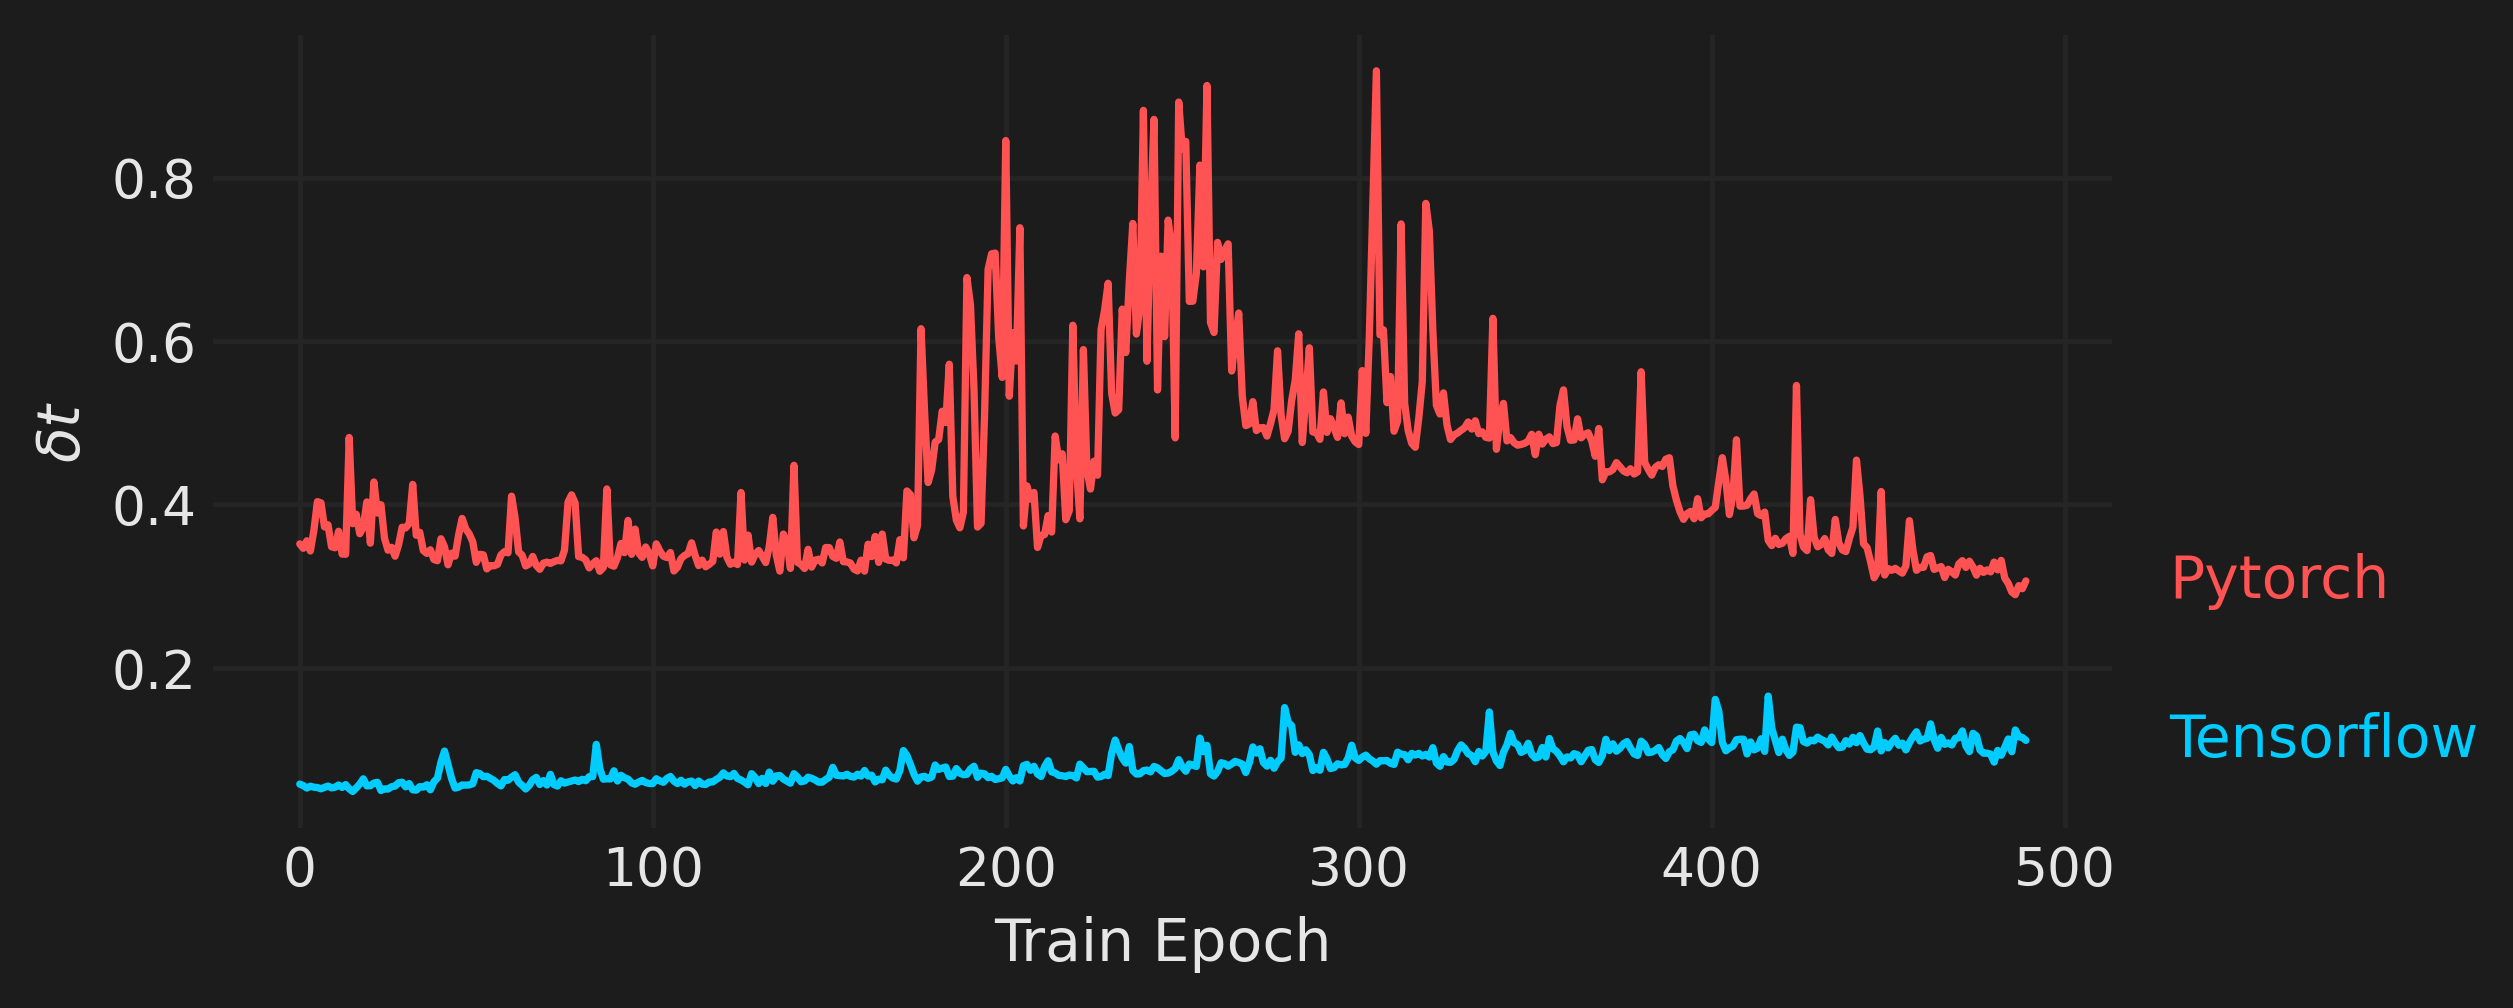

In [23]:
fig, ax = plot_both(ytf=history_tf_['dt'][10:], ypt=history_pt_['dt'][10:], xlabel='Train Epoch', ylabel=r'$\delta t$')

In [24]:
def stack_directional_history_tf(history):
    hist = {}
    for key in history[0].keys():
        hist[key] = tf.stack([x.get(key) for x in history]).numpy()
        
    return hist

def stack_directional_history_pt(history):
    hist = {}
    for key in history[0].keys():
        hist[key] = torch.stack([x.get(key) for x in history]).detach().numpy()
        
    return hist

In [25]:
keys = [str(i) for i in range(len(history_tf['forward']))]
history_tf_ = dict(zip(keys, history_tf['forward']))

history_tf.keys()
history_tf_.keys()
history_tf['forward'][0].keys()

dict_keys(['acc', 'acc_mask', 'logdet', 'forward', 'backward', 'dt', 'loss'])

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487', '488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499'])

dict_keys(['xeps', 'veps', 'energy', 'logdet', 'logprob', 'acc', 'sumlogdet'])

In [26]:
history_tf_fwd = {}
for key in history_tf['forward'][0].keys():
    history_tf_fwd[key] = [x.get(key) for x in history_tf['forward']]

In [27]:
htf_fwd = tf.stack(history_tf_fwd['energy'])

In [28]:
history_pt_fwd = {}
for key in history_pt['forward'][0].keys():
    history_pt_fwd[key] = [x.get(key) for x in history_pt['forward']]

In [29]:
def stack(x):
    try:
        if isinstance(x, list):
            if isinstance(x[0], tf.Tensor):
                return tf.stack(x).numpy()
            if isinstance(x[0], torch.Tensor):
                try:
                    return torch.stack(x).detach().numpy()
                except:
                    return torch.Tensor(x).detach().numpy()
            return np.stack(x)
        return np.stack(x)
    except:
        return np.zeros_like(x)
        
        
history_pt_fwd_ = {}
for key, val in history_pt_fwd.items():
    try:
        history_pt_fwd_[key] = stack(val)
    except:
        history_pt_fwd_[key] = np.zeros_like(val)
        
history_tf_fwd_ = {}
for key, val in history_tf_fwd.items():
    if key == 'sumlogdet':
        continue
    try:
        history_tf_fwd_[key] = stack(val)
    except:
        history_tf_fwd_[key] = []

Saving figure to: plots/train_history-1641843888.786603.png

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Overpass
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Overpass


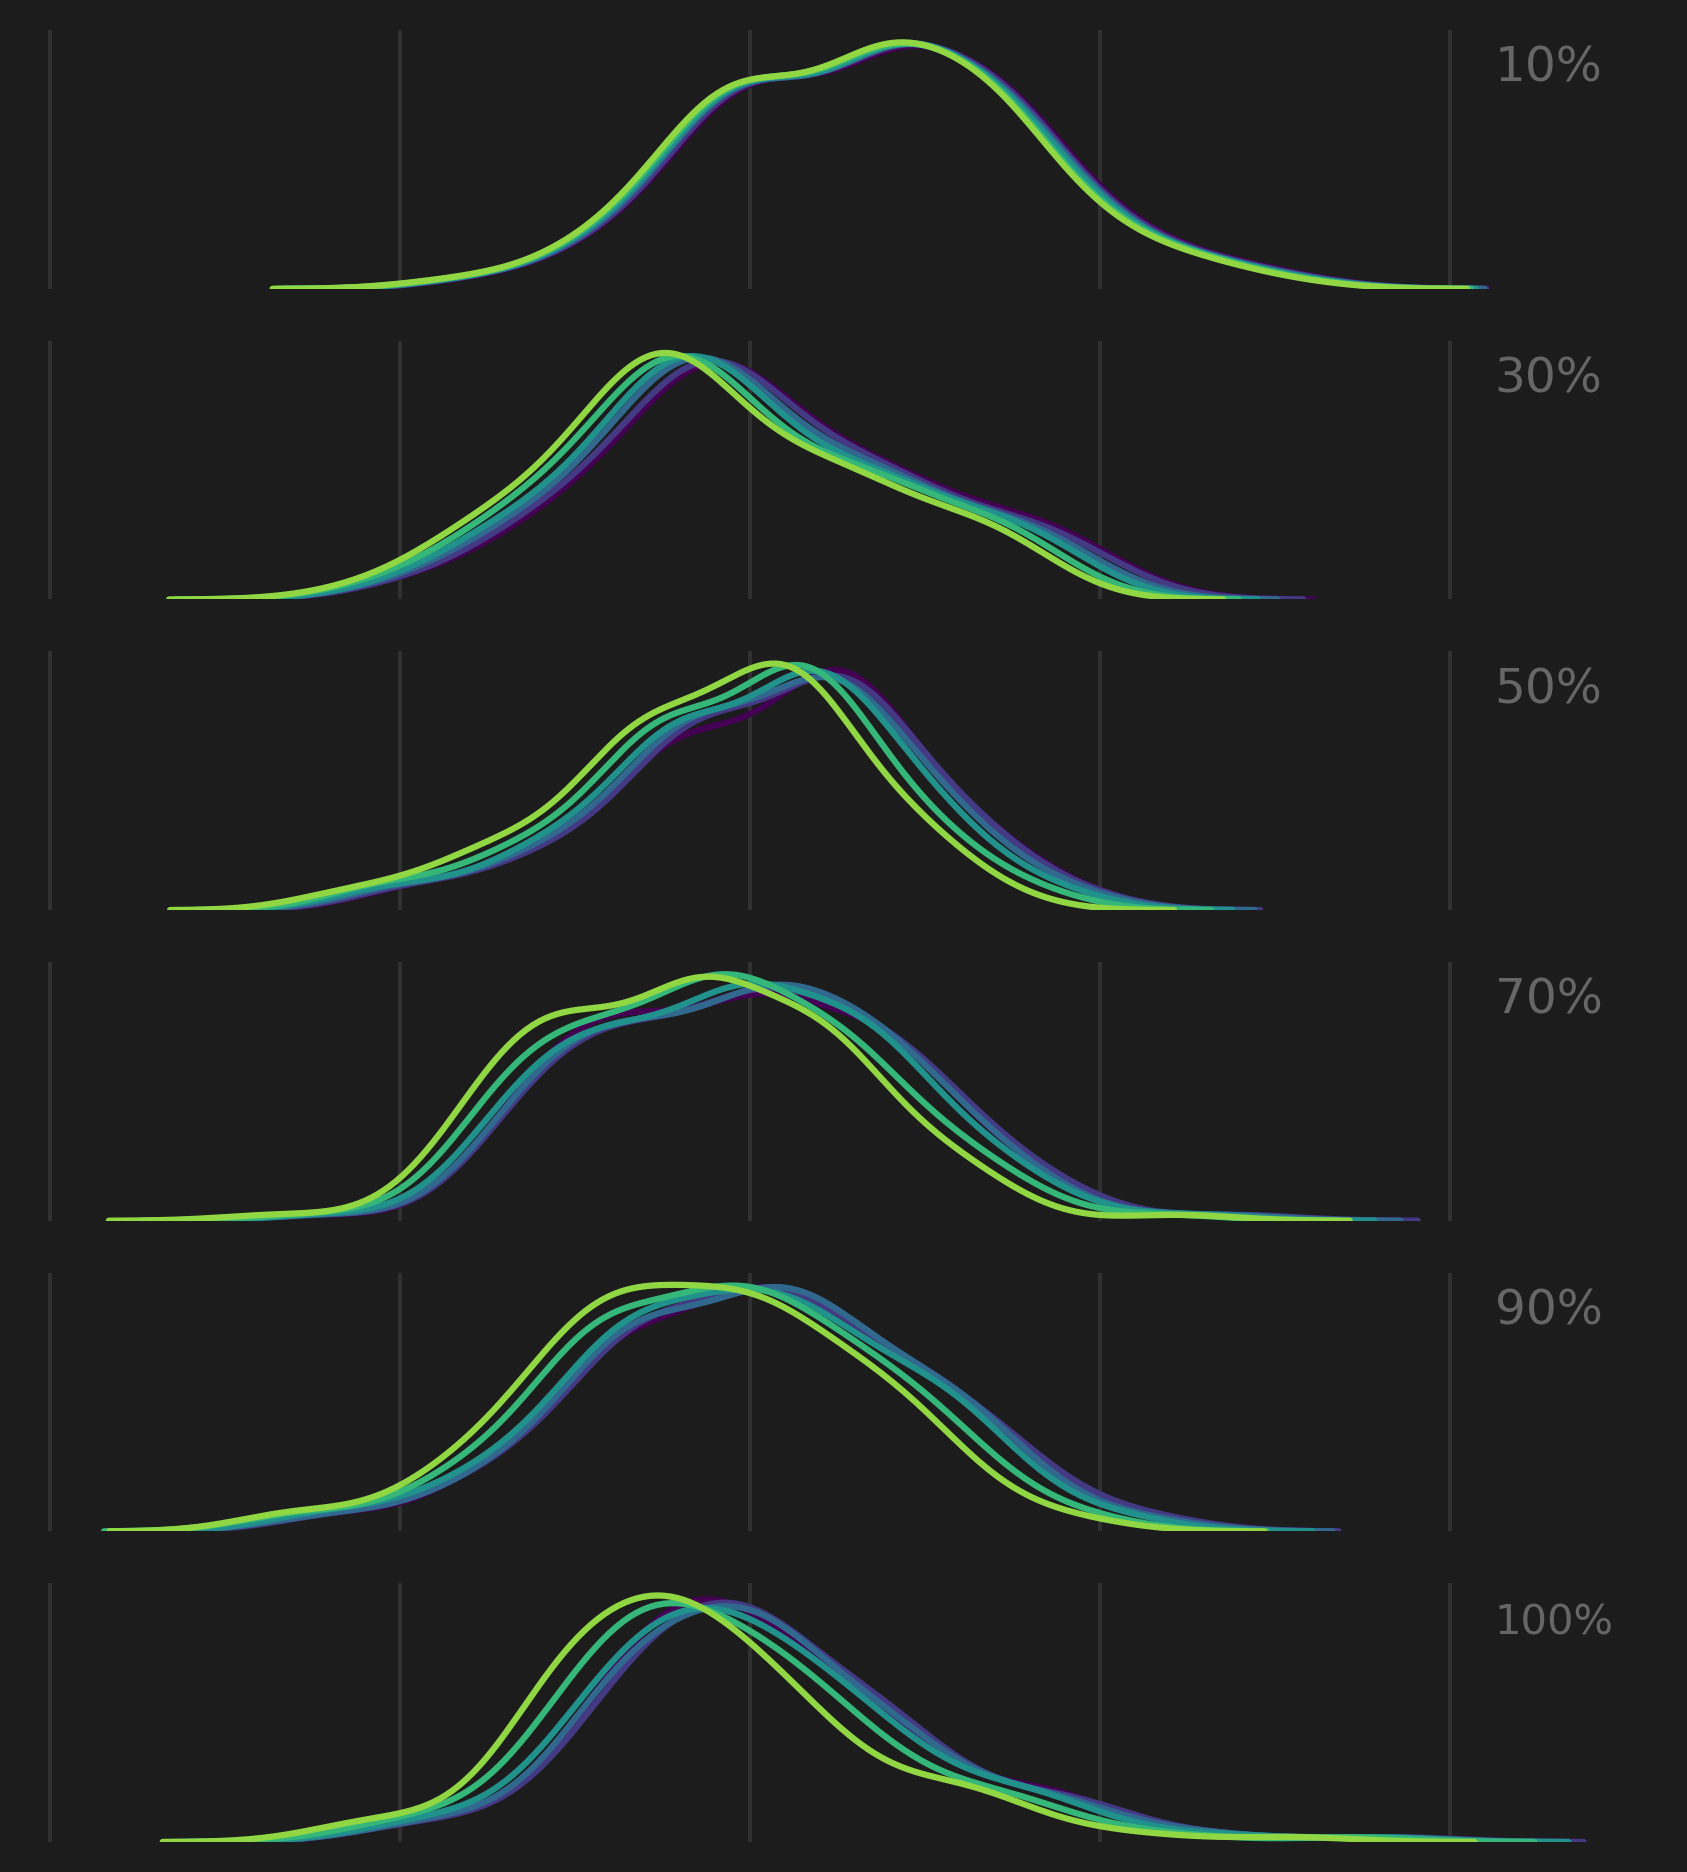

In [30]:
from pathlib import Path
import matplotx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
plt.style.use('~/.config/matplotlib/stylelib/molokai.mplstyle')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.grid'] = False
sns.set_palette(['#00CCFF', '#FF5252', '#63FF5B', '#AE81FF', '#Fd971f'])
plt.rcParams['image.cmap'] = 'viridis'


colors = plt.get_cmap('viridis')
lfcolors = {
    i: colors(i) for i in range(history_pt_fwd_['energy'].shape[1])
}

nrows = 5
efwd_pt = history_pt_fwd_['energy']  # shape: (ntrain, nlf, batch_size)
ntrain, nlf, batch_size = history_pt_fwd_['energy'].shape
steps = ntrain // nrows
idxs = np.arange(0, ntrain, steps)
idxs = np.arange(50, ntrain, ntrain // nrows)
fig, axes = plt.subplots(figsize=(7, 8), nrows=nrows+1, sharex=True)
with plt.style.context(matplotx.styles.dufte):
    for idx in range(nrows):
        ax = axes.flatten()[idx]
        y = efwd_pt[idxs[idx]]
        for lf in range(nlf):
            color = colors(lf / nlf)
            #label = f'{int(steps)}% trained' #if lf == nlf - 1 else None
            label = f'lf: {lf}' if idx == 0 else None
            _ = sns.kdeplot(y[lf], color=color, label=label, ax=ax);
        _ = ax.grid(True, color='#303030', axis='x')
        _ = ax.grid(False, axis='y')
        _ = matplotx.line_labels(ax=ax);
        _ = ax.set_ylabel('');
        _ = ax.set_yticklabels([]);
        _ = ax.set_xticklabels([]);
        xy = (0.9, 0.8)
        _ = ax.text(*xy, f'{int(100*idxs[idx]/ntrain)}%', transform=ax.transAxes, color='#666666', fontsize='small')

ax = axes.flatten()[-1]
y = efwd_pt[-1]        
for lf in range(nlf):
    color = colors(lf / nlf)
    #label = f'{int(steps)}% trained' #if lf == nlf - 1 else None
    label = f'lf: {lf}' if idx == 0 else None
    _ = sns.kdeplot(y[lf], color=color, label=label, ax=ax);

_ = ax.text(*xy, f'100%', transform=ax.transAxes, color='#666666', fontsize='small')
_ = ax.set_ylabel('');
_ = ax.set_yticklabels([]);
_ = ax.grid(True, color='#303030', axis='x')
_ = ax.grid(False, axis='y')
outdir = Path('.').joinpath('plots')
outfile = outdir.joinpath(f'train_history-{time.time()}.png')
print(f'Saving figure to: {outfile.as_posix()}')
_ = plt.savefig(outfile.as_posix(), transparent=True, dpi=750)

In [ ]:
import arviz as az
import xarray as xr

dataset_fwd_pt = {}
for key, val in history_pt_fwd_.items():
    #fig, ax = plt.subplots()
    darr = xr.DataArray(val.tranpose()
    dataset_fwd_pt[key] = darr
    #print(f'{key}: {val.shape}')
    
dataset_fwd_pt = xr.Dataset(dataset_fwd_pt)

### Save the plot from the previous run

In [ ]:
losses_arr_tf = np.stack(list(losses_tf.values())).flatten()

with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(figsize=(8, 6))
    _ = ax.plot(np.arange(len(losses_arr_tf)), losses_arr_tf, label='Tensorflow');
    _ = ax.plot(np.arange(len(losses_arr)), losses_arr, label='Pytorch');
    _ = ax.set_xlabel(r'Train Epoch')
    _ = ax.set_ylabel('loss')
    matplotx.line_labels()  # line labels to the right